This notebook present a series of simple example on how to use `pyafs.afs` to normalise the spectra data with Alpha-shape Fitting to Spectrum (AFS) method. The sample spectral data are taken from [the original repository](https://github.com/xinxuyale/AFS/tree/master/examples).


In [1]:
import pyafs

pyafs.__version__

'0.1.5'

# Import & Visualise Spectral Data

In [2]:
import pandas as pd

In [3]:
# import sample echelle spectrum from the original repository
spec_df = pd.read_csv(
    'data/ExampleSpectrum.csv', skiprows=1, names=['wvl', 'intensity']
)
spec_df.head(n=10)

wvl    intensity
0  4989.459023  13275.41016
1  4989.470168  13555.55371
2  4989.481313  13590.04980
3  4989.492456  13561.42090
4  4989.503600  13615.58594
5  4989.514742  13681.70020
6  4989.525884  13517.30078
7  4989.537025  13829.33691
8  4989.548166  13291.32129
9  4989.559306  13492.75391

In [4]:
import matplotlib.pyplot as plt

In [5]:
# visualise methods
def plot_spec_frame():
    fig, axis = plt.subplots(1, 1, figsize=(10, 4), dpi=300)

    axis.set_xlabel('wavelength [$\AA$]')
    axis.set_ylabel('intensity')
    axis.tick_params(axis='both', direction='in', top=True, right=True)

    return fig, axis


def plot_spec(
        plot_df: pd.DataFrame, flux_key: str
) -> None:
    fig, axis = plot_spec_frame()

    axis.plot(plot_df['wvl'], plot_df[flux_key], '-', color='tab:blue', lw=.6)


def plot_norm_spec(
        plot_df: pd.DataFrame, flux_key: str
) -> None:
    fig, axis = plot_spec_frame()

    axis.plot(plot_df['wvl'], plot_df[flux_key], '-', color='tab:blue', lw=.6)

    axis.axhline(1, color='k', ls=':')


def plot_norm_spec_compare(
        plot_df: pd.DataFrame, flux_a_key: str, flux_b_key: str
):
    fig, axis = plot_spec_frame()

    for flux_key, flux_colour in zip([flux_a_key, flux_b_key], ['tab:red', 'tab:blue']):
        axis.plot(plot_df['wvl'], plot_df[flux_key], '-',
                  color=flux_colour, lw=.6, label=flux_key.replace('_', ' '))

    axis.plot(plot_df['wvl'], plot_df[flux_a_key] - plot_df[flux_b_key], '-',
              color='tab:purple', lw=.6,
              label=f'{flux_a_key.replace("_", " ")} - {flux_b_key.replace("_", " ")}')

    axis.axhline(1, color='k', ls=':', lw=.8)
    axis.axhline(0, color='k', ls='--', lw=.6)

    axis.legend(ncol=3, loc='upper center')
    axis.set_ylim(-.1, 1.2)

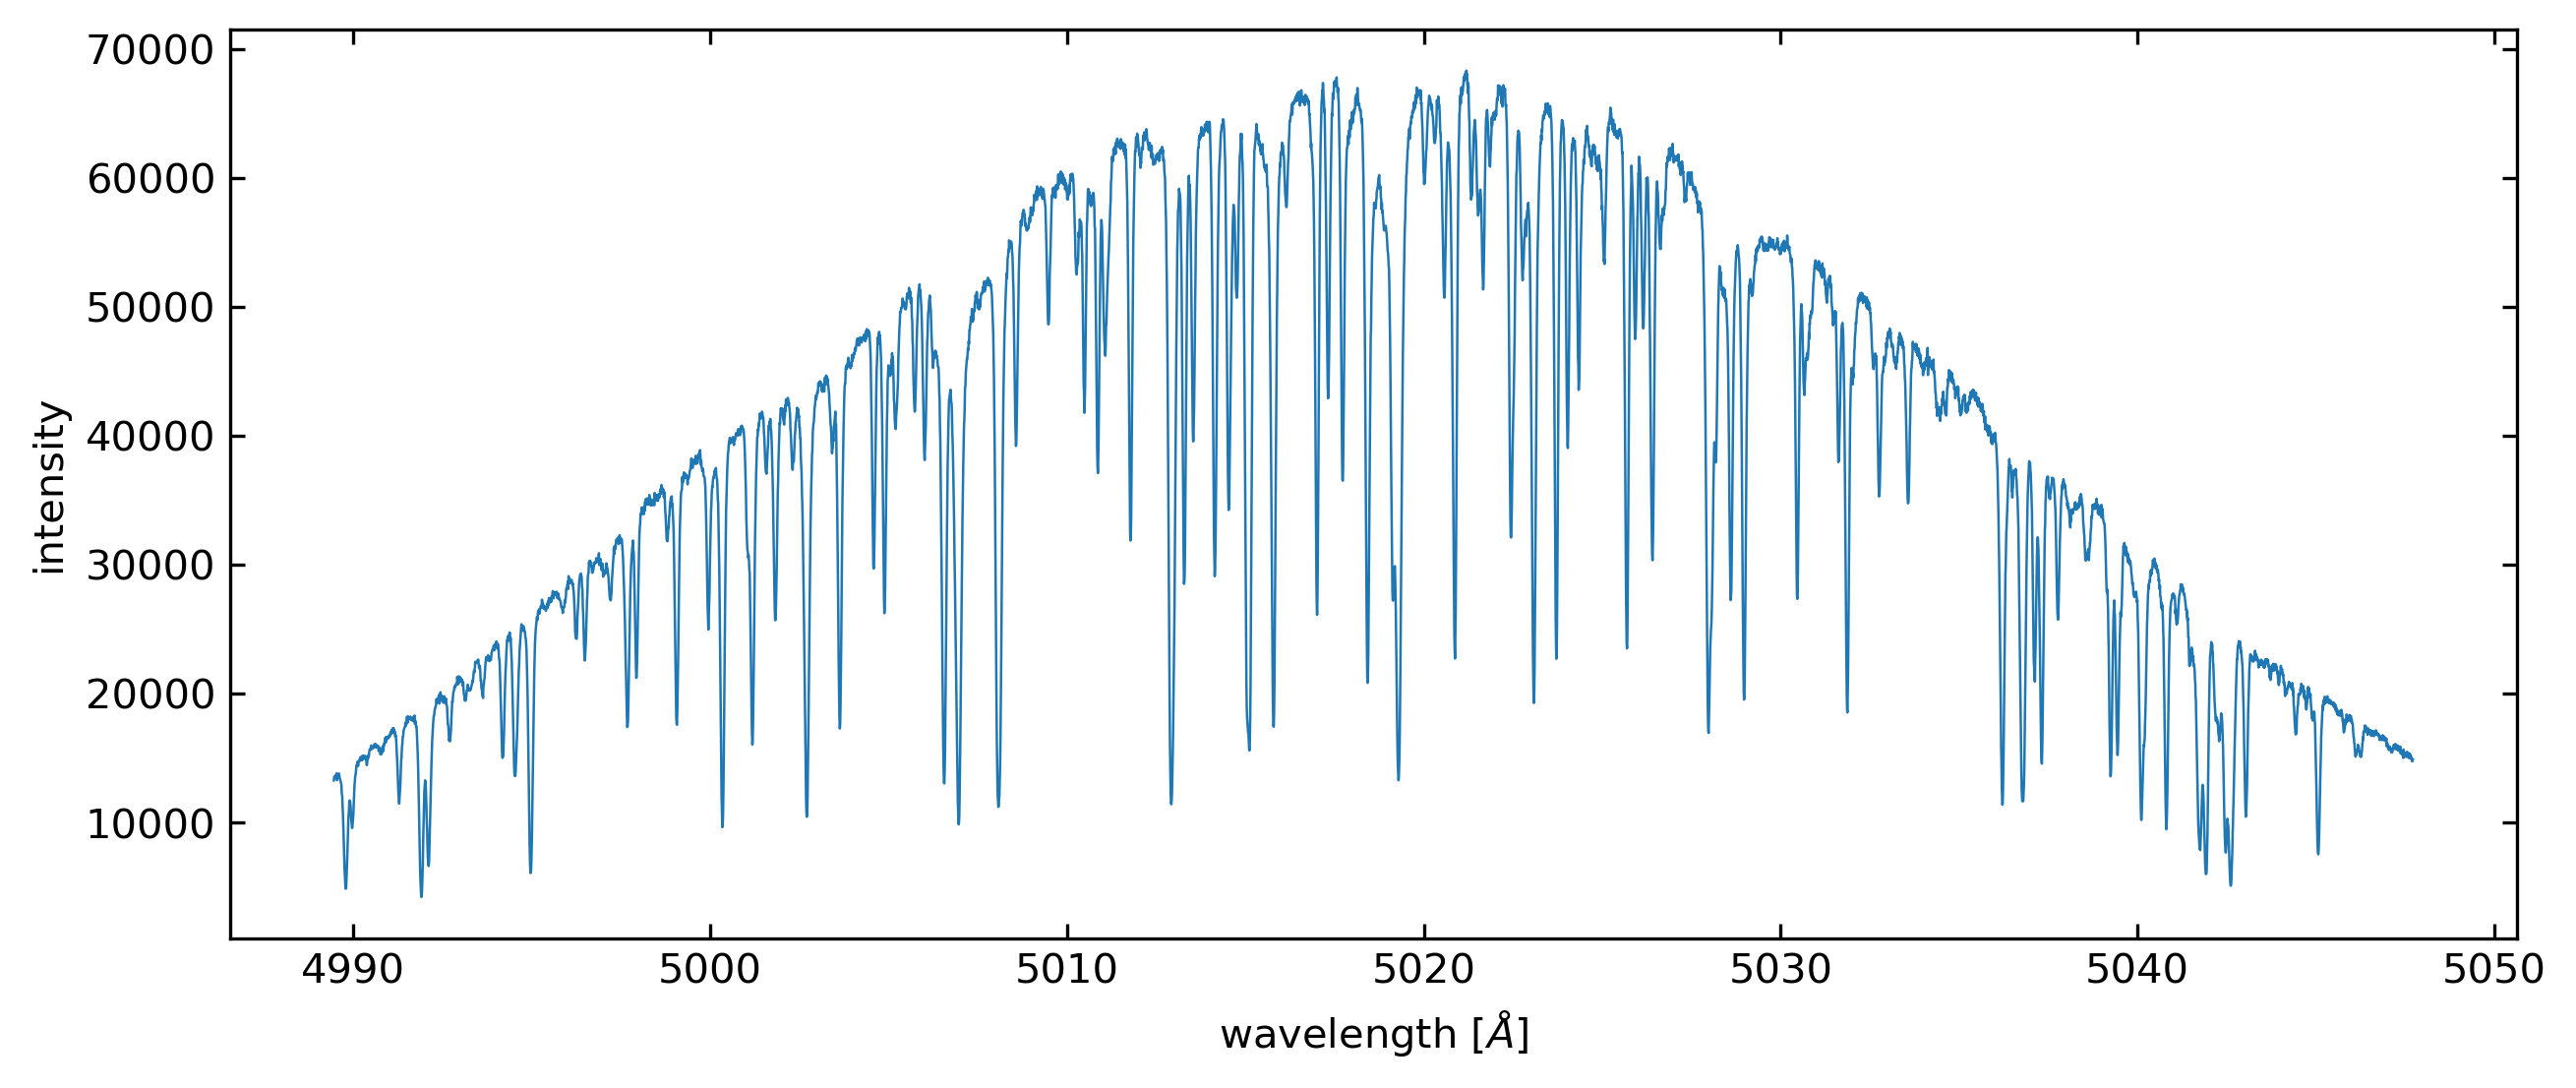

In [6]:
# visualisation of the sample spectrum
plot_spec(spec_df, 'intensity')

# AFS Normalisation

The AFS algorithm follows these steps:

- **Step 0**: Load the observed spectrum ${(\lambda_i, y_i)}^n_{i=1}$, where $\lambda_i$ and $y_i$ are the wavelength and intensity of the spectrum at the $i$-th pixel.

- **Step 1**: Scale the spectral intensity with $u=\dfrac{\mathrm{max}(\lambda)-\mathrm{min}(\lambda)}{10\,\mathrm{max}(y)}$.

- **Step 2**: Construct the alpha shape $\mathrm{AS}_\alpha$ with radius $\alpha$, then calculate its upper boundary ${\widetilde{\mathrm{AS}}}_{\alpha }=\left\{({\lambda }_{i},\tilde{y}({\lambda }_{i})):{\lambda }_{i}\in \left\{{\lambda }_{i},i\,=\,1,...,n\right\},\,\tilde{y}({\lambda }_{i})=\mathop{\max }\limits_{\forall ({\lambda }_{i},{y}_{i}^{* })\in {\mathrm{AS}}_{\alpha }}{y}_{i}^{* }\right\}$.

- **Step 3**: Apply smoothing on ${\widetilde{\mathrm{AS}}}_{\alpha }$ to estimate the primitive blaze function ${\hat{B}}_{1}$. Calculate the primitive normalized spectrum ${\hat{y}}^{(1)}=\dfrac{y}{{\hat{B}}_{1}}$.

- **Step 4**: Identify the intersections ${W}_{\alpha }={\widetilde{\mathrm{AS}}}_{\alpha }\cap {\left\{({\lambda }_{i},{y}_{i})\right\}}_{i=1}^{n}=\left\{({\lambda }_{i},{y}_{i}),i={w}_{1},{w}_{2},...,{w}_{| {W}_{\alpha }| }\right\}$, where ${w}_{1},{w}_{2},...,{w}_{| {W}_{\alpha }| }$ are the indices of the intersection points. Afterwards, find the pixels that are above the blaze function with a certain quantile $q$ in segments formed by adjacent intersection points, i.e., ${S}_{j,\alpha ,q}=\left\{{w}_{j}\leqslant i\leqslant {w}_{j+1}:\dfrac{{\sum }_{k={w}_{j}}^{{w}_{j+1}}{\mathbb{1}}({\hat{y}}_{i}^{(1)}\geqslant {\hat{y}}_{k}^{(1)})}{{w}_{j+1}-{w}_{j}+1}\geqslant q\right\}$. Denote the union of all ${S}_{j,\alpha ,q}$ as ${S}_{\alpha ,q}=\bigcup _{j=1}^{| {W}_{\alpha }|-1}{S}_{j,\alpha ,q}$.

- **Step 5**: Apply smoothing on ${S}_{\alpha ,q}$ to estimate the final blaze function ${\hat{B}}_{2}$.

- **Step 6**: Calculate the final normalized spectrum ${\hat{y}}^{(2)}=\dfrac{{\hat{y}}^{(1)}}{{\hat{B}}_{2}}$.

**Implementation Extensions**

This implementation extends the original algorithm by offering two smoothing methods:

- **LOESS** (Original method used in AFS, default) Local polynomial regression fitting with fraction of data points (`frac`) and polynomial degree (`degree`) as parameters.

- **UnivariateSpline** (Alternative method) Univariate spline interpolation with smoothing factor (`s`) and polynomial degree (`k`) as parameters.


In [7]:
from pyafs import afs

**Required Arguments**

- `wvl`: spectral wavelength
- `intensity`: spectral intensity

**Optional Arguments**

- `alpha_radius`: alpha-shape radius (default: wavelength range / 10)
- `continuum_filter_quantile`: quantile threshold $q$ for pixel filtering near primary blaze function \[*Step 4*\] (default: 0.95)
- `primitive_blaze_smoothing`: primitive blaze smoothing method (default: 'loess')
- `final_blaze_smoothing`: final blaze smoothing method (default: 'loess')
- `is_include_intersections`: include $\widetilde{\mathrm{AS}}_\alpha$ intersection points for refining blaze (default: False)
- `is_remove_outliers`: remove spectral outliers (default: True)
- `debug`: enable diagnostic plots. If a string is provided, it will be used as the output directory for the diagnostic plots. (default: False)

**Outlier Detection Parameters**

Available when `is_remove_outliers=True`:

- `outlier_rolling_window`: Rolling median filter window size (default: 80)
- `outlier_rolling_baseline_quantile`: Rolling baseline quantile (default: 0.8)
- `outlier_rolling_mad_scale`: Rolling median filter scale factor (default: 1.4)
- `outlier_max_iterations`: Maximum outlier removal iterations (default: 2)


**Smoothing Parameters**

Control smoothing behaviour using (stage)_smooth_(arg) format, where (stage) is either primitive or final. Pass as additional keyword arguments.

- For _LOESS_ ('loess'):

  - `*_smoothing_frac`: fraction of data points for local fitting (default: 0.25)
  - `*_smoothing_degree`: polynomial degree (default: 2)

- For _UnivariateSpline_ ('spline'):

  - `*_smoothing_s`: smoothing factor (default: 0.01)
  - `*_smoothing_k`: spline degree (default: 3)

Note: Replace `*` with either `primitive` or `final` to specify the smoothing stage.

**Return Values**

- `debug=False`: normalised intensity
- `debug=True`: normalised intensity and DataFrame storing intermediate results


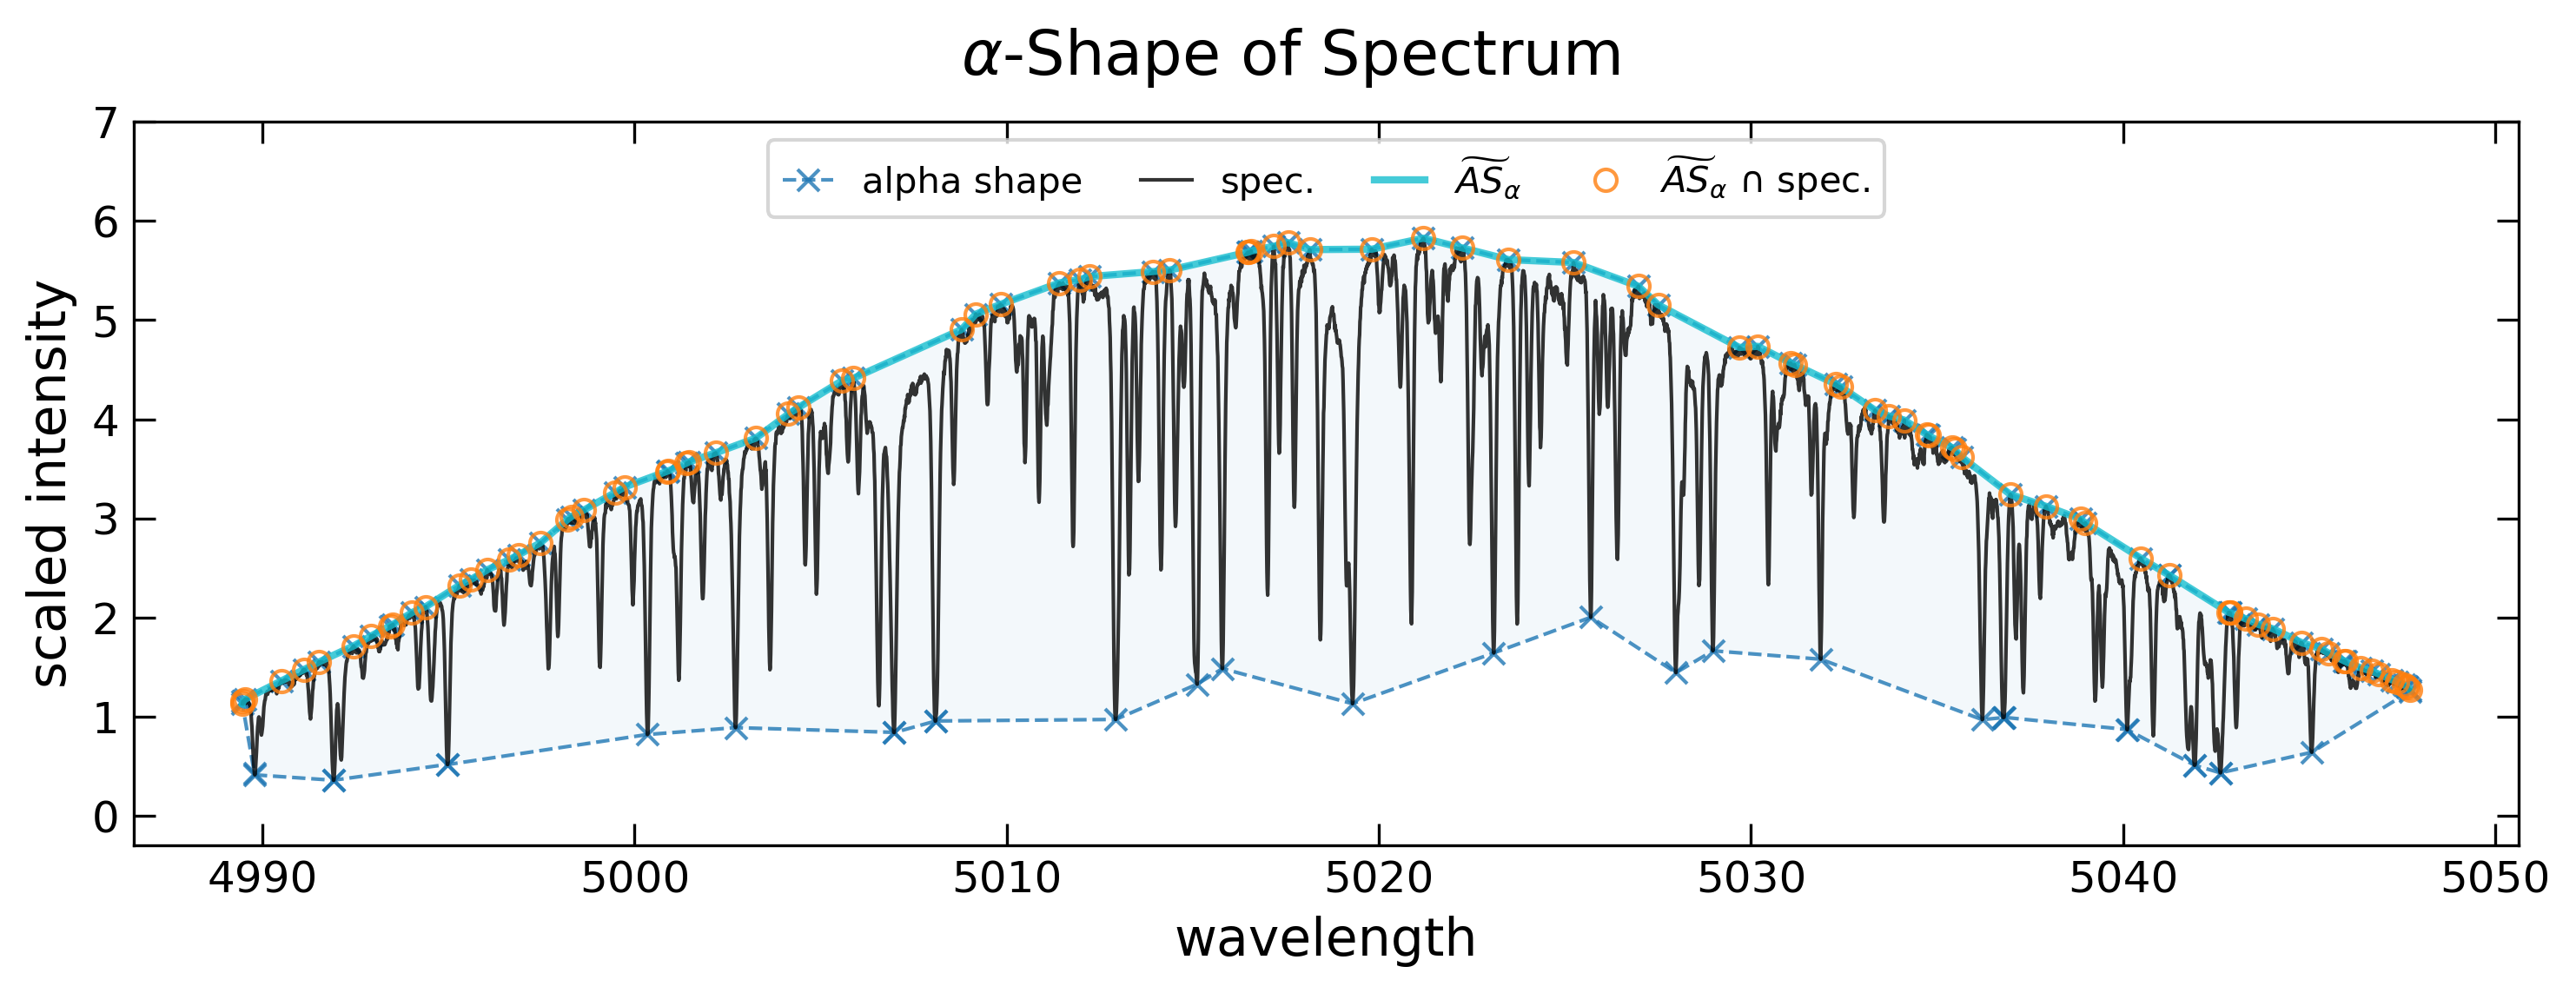

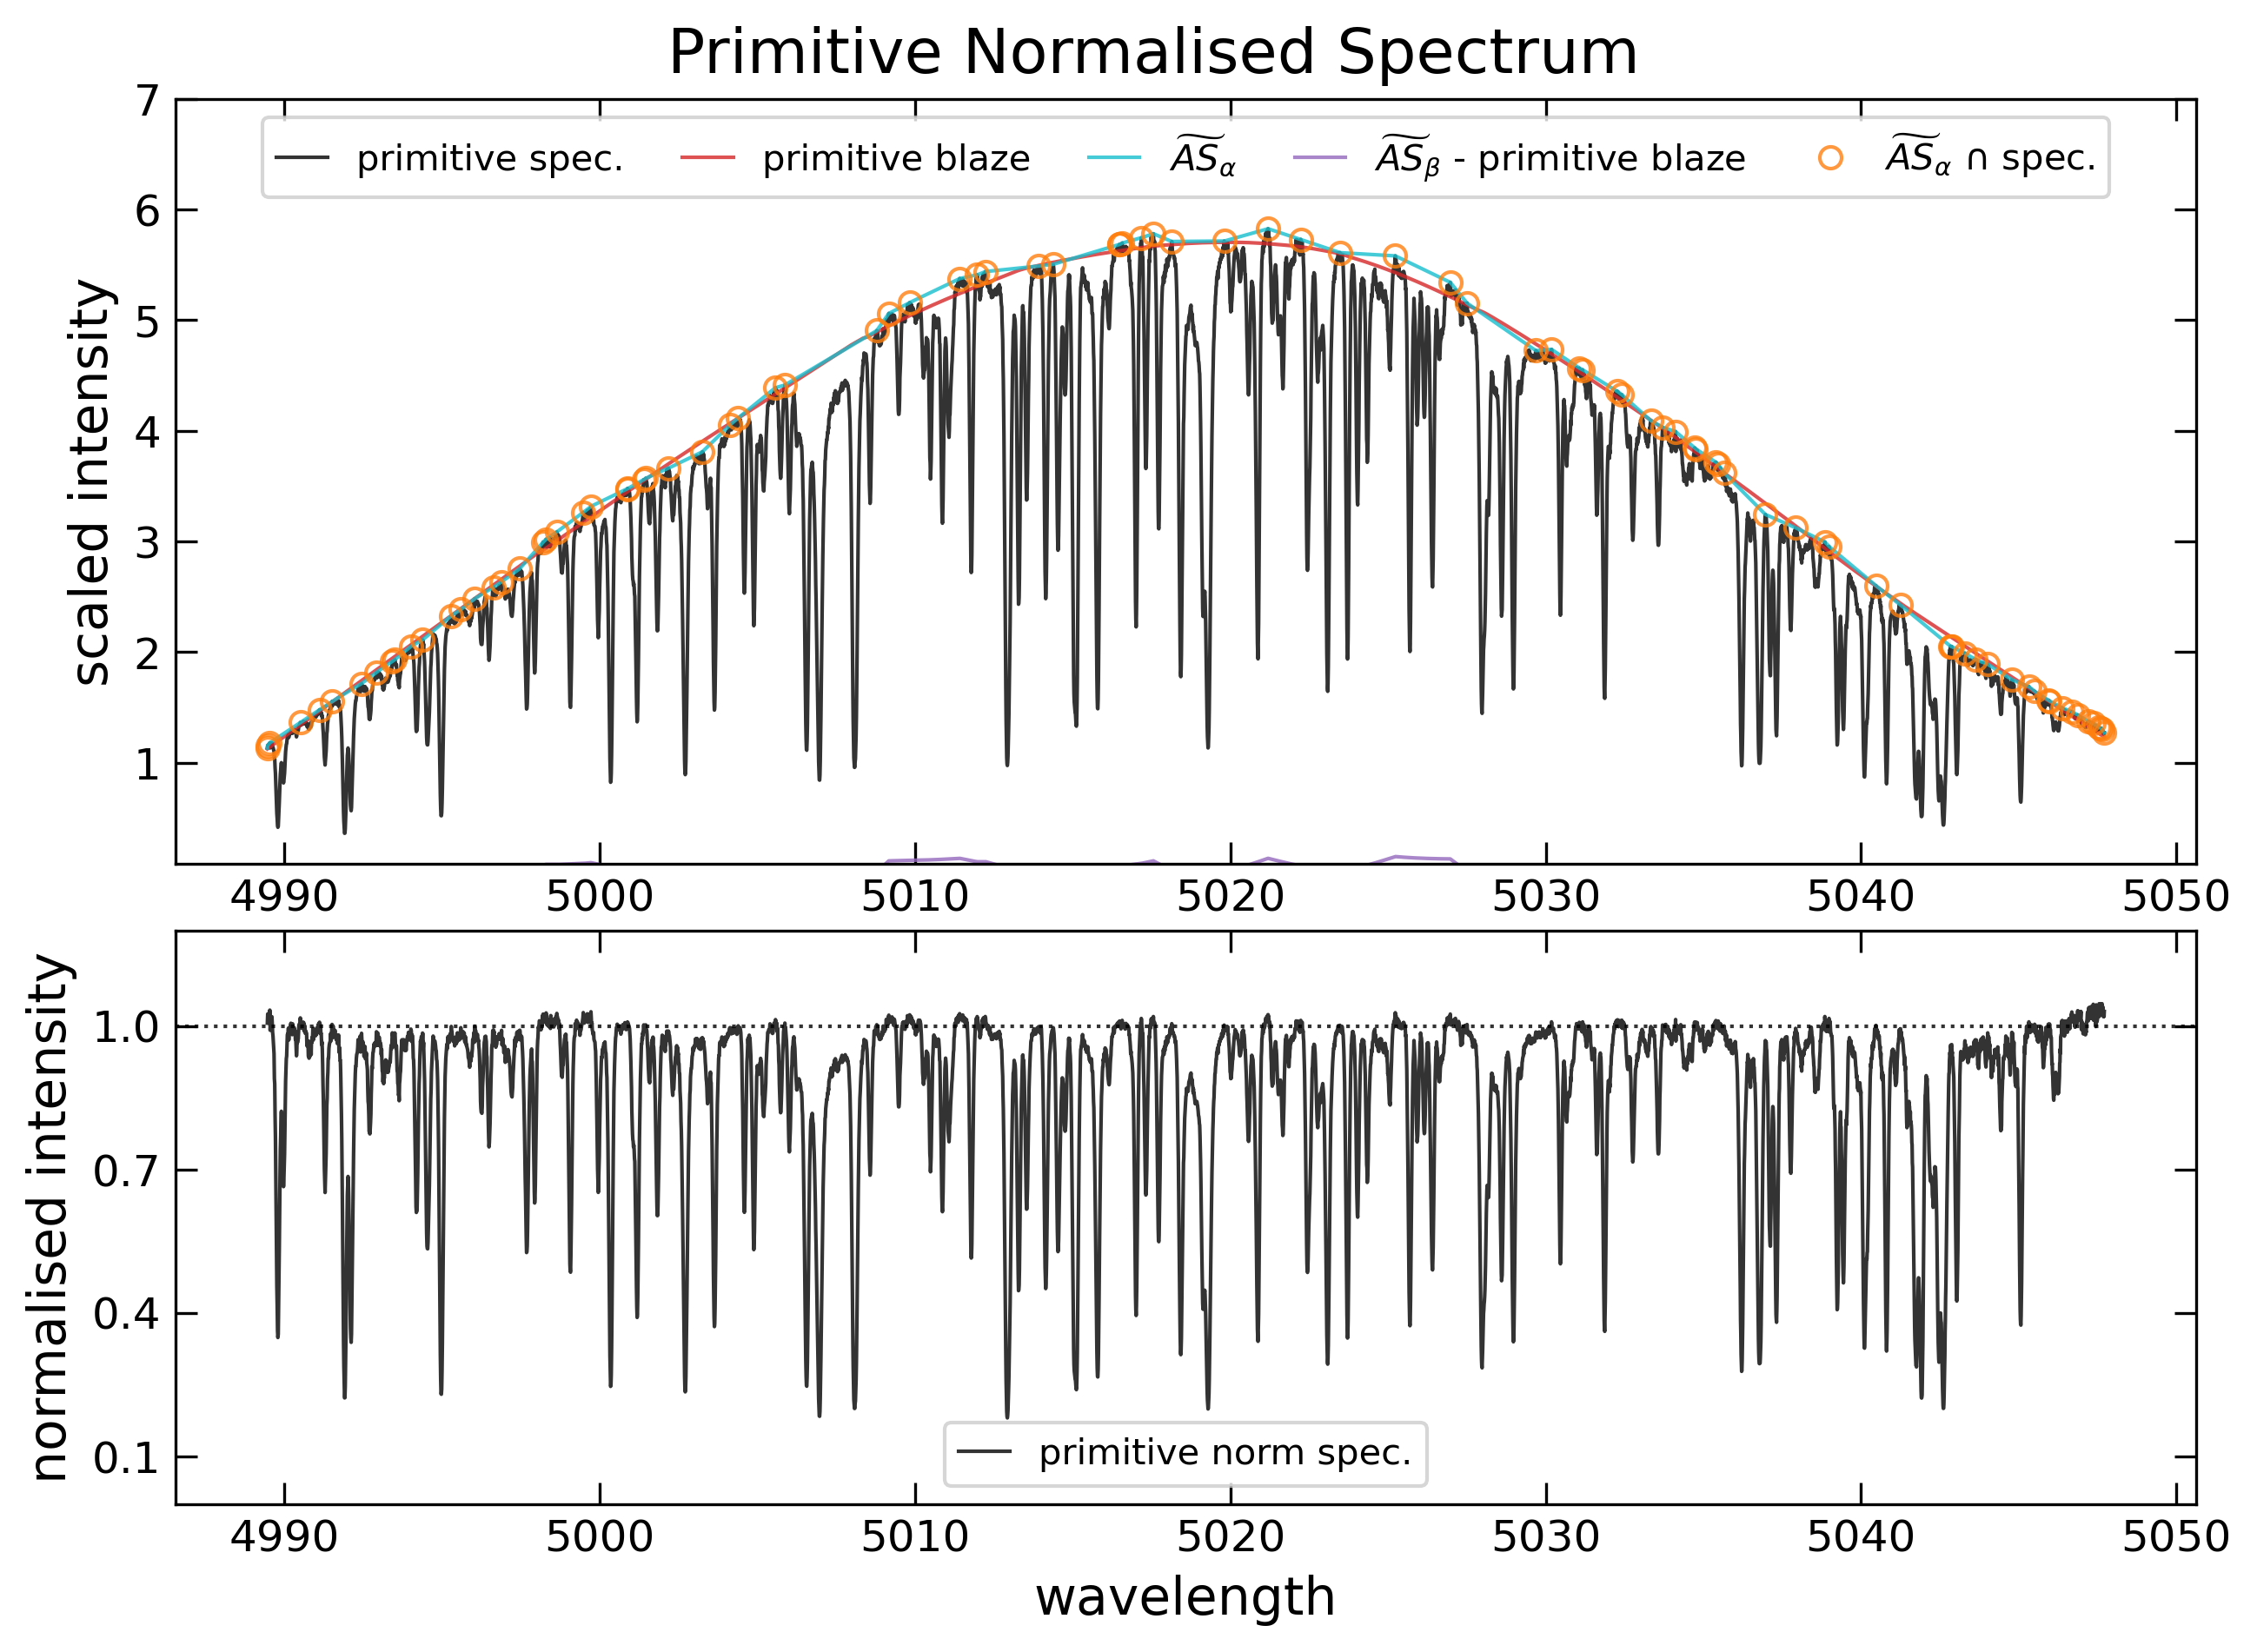

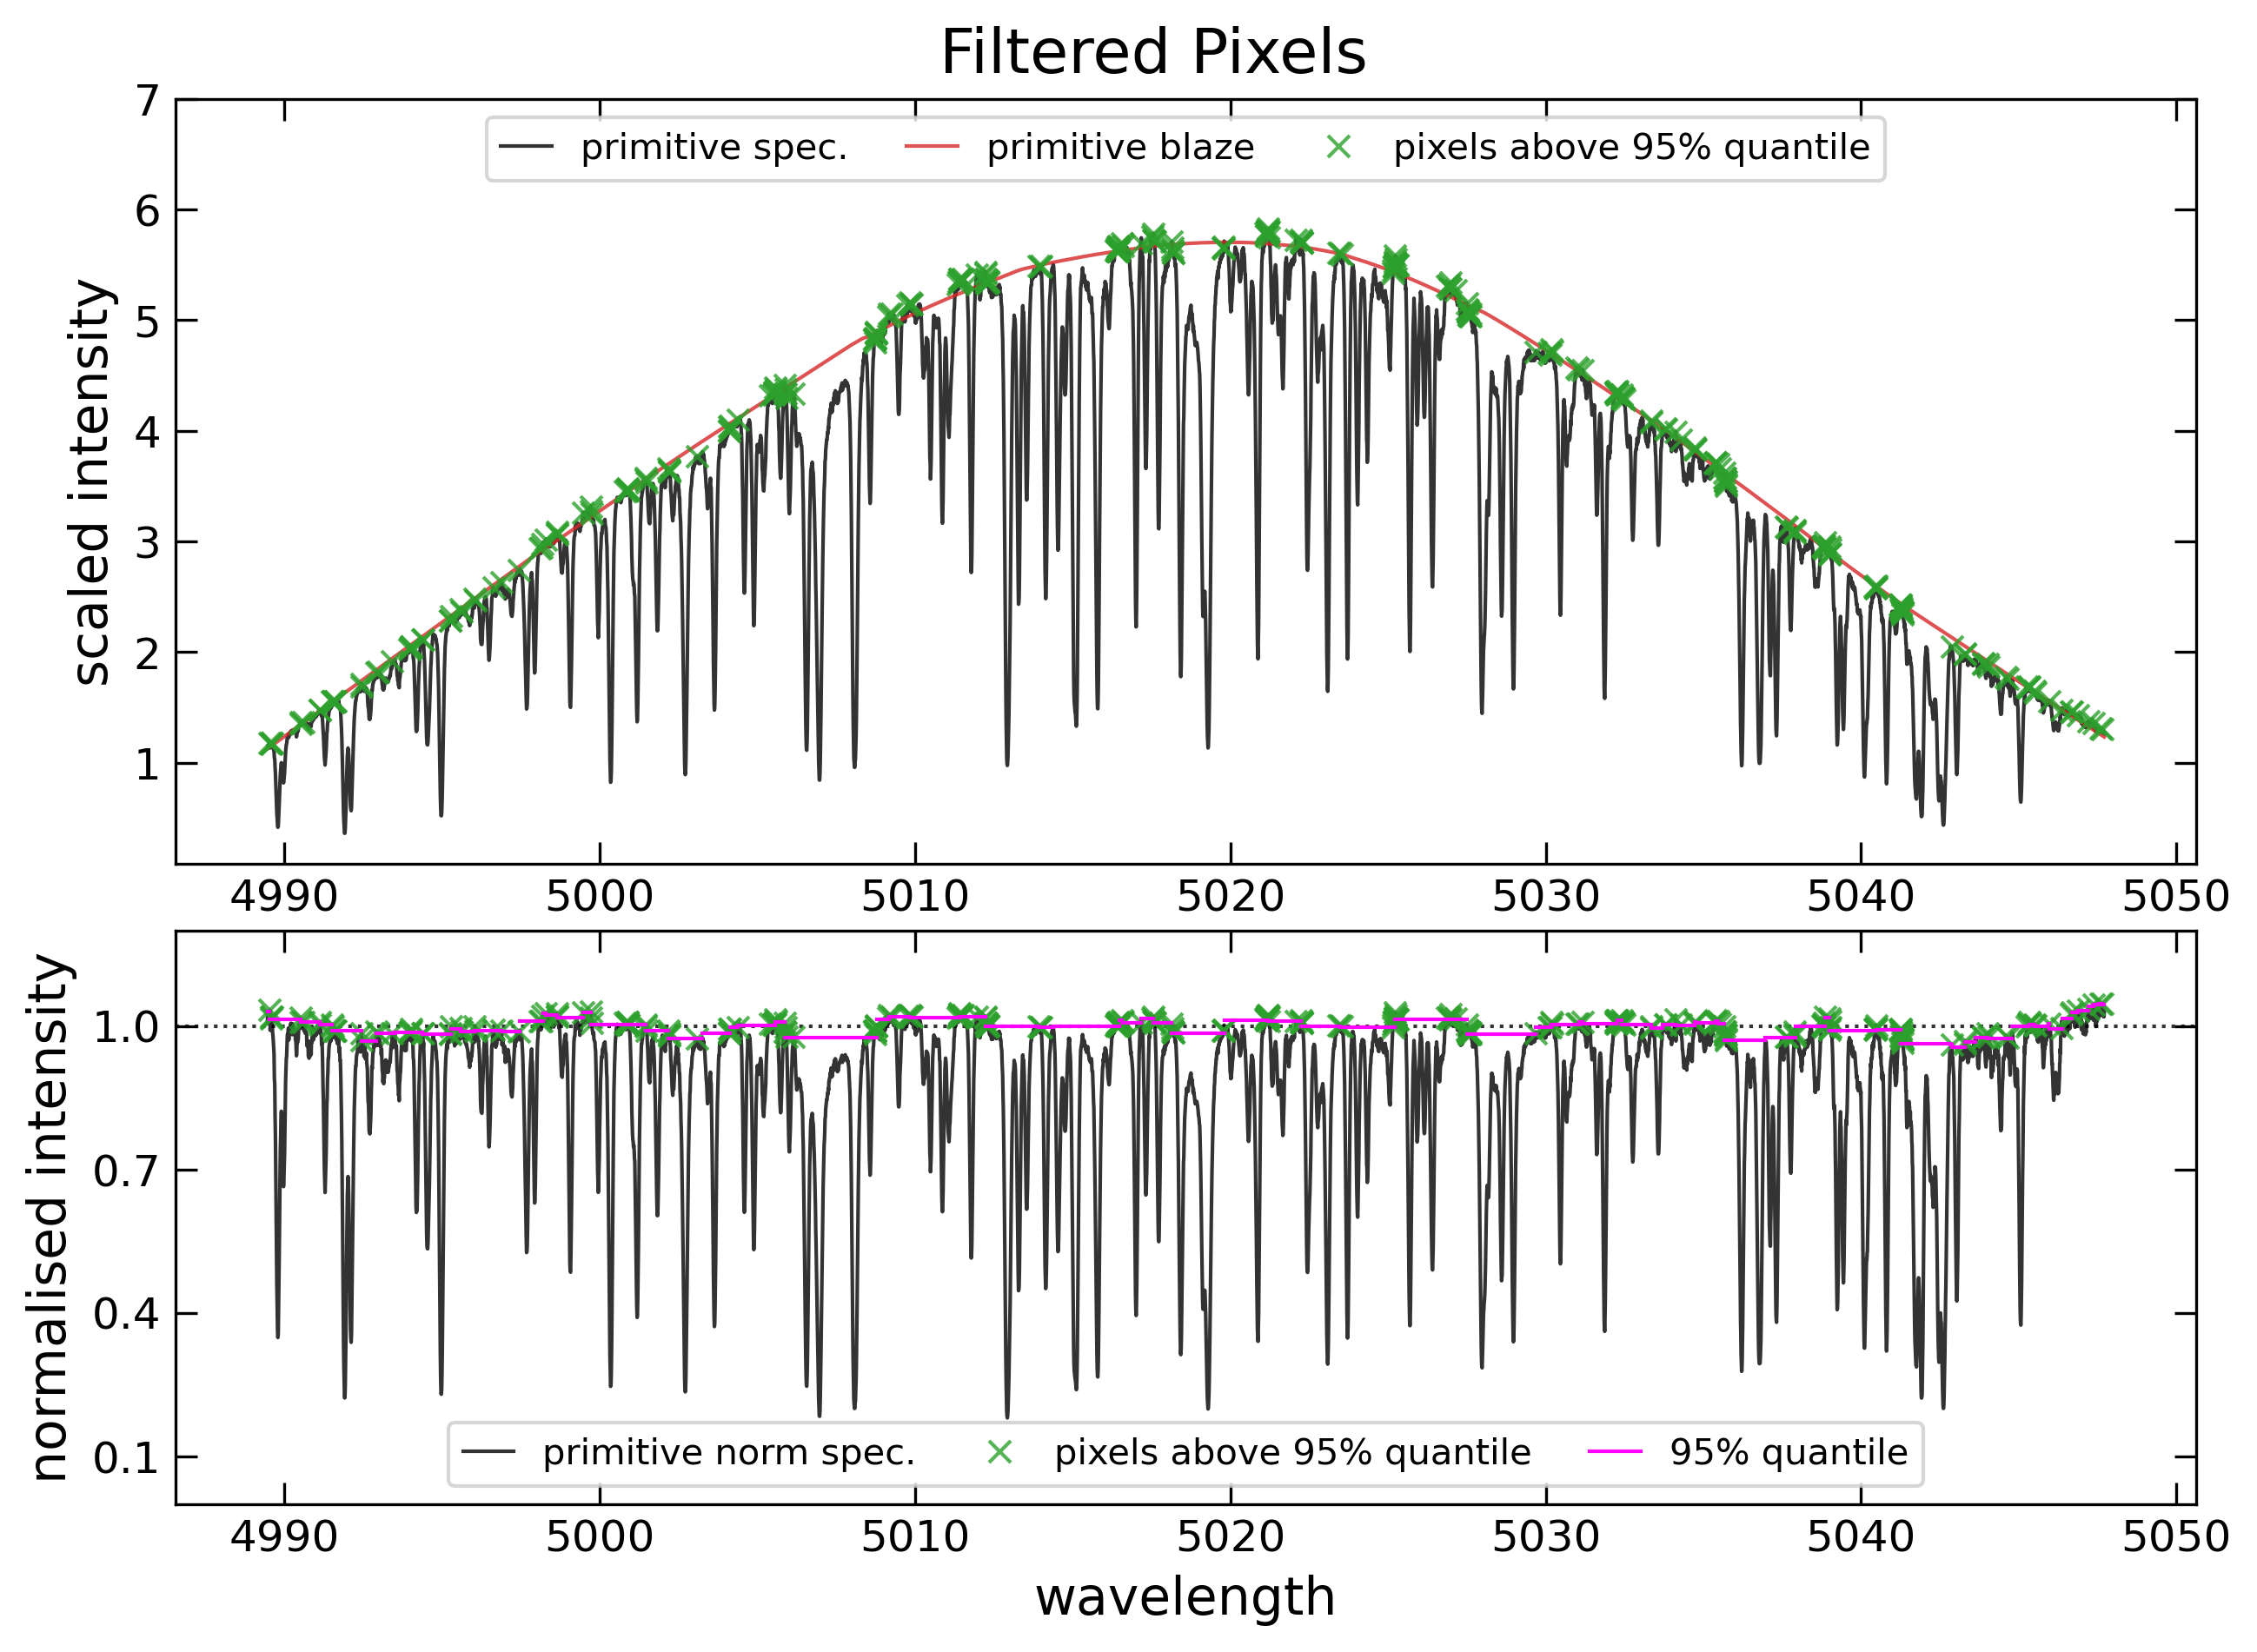

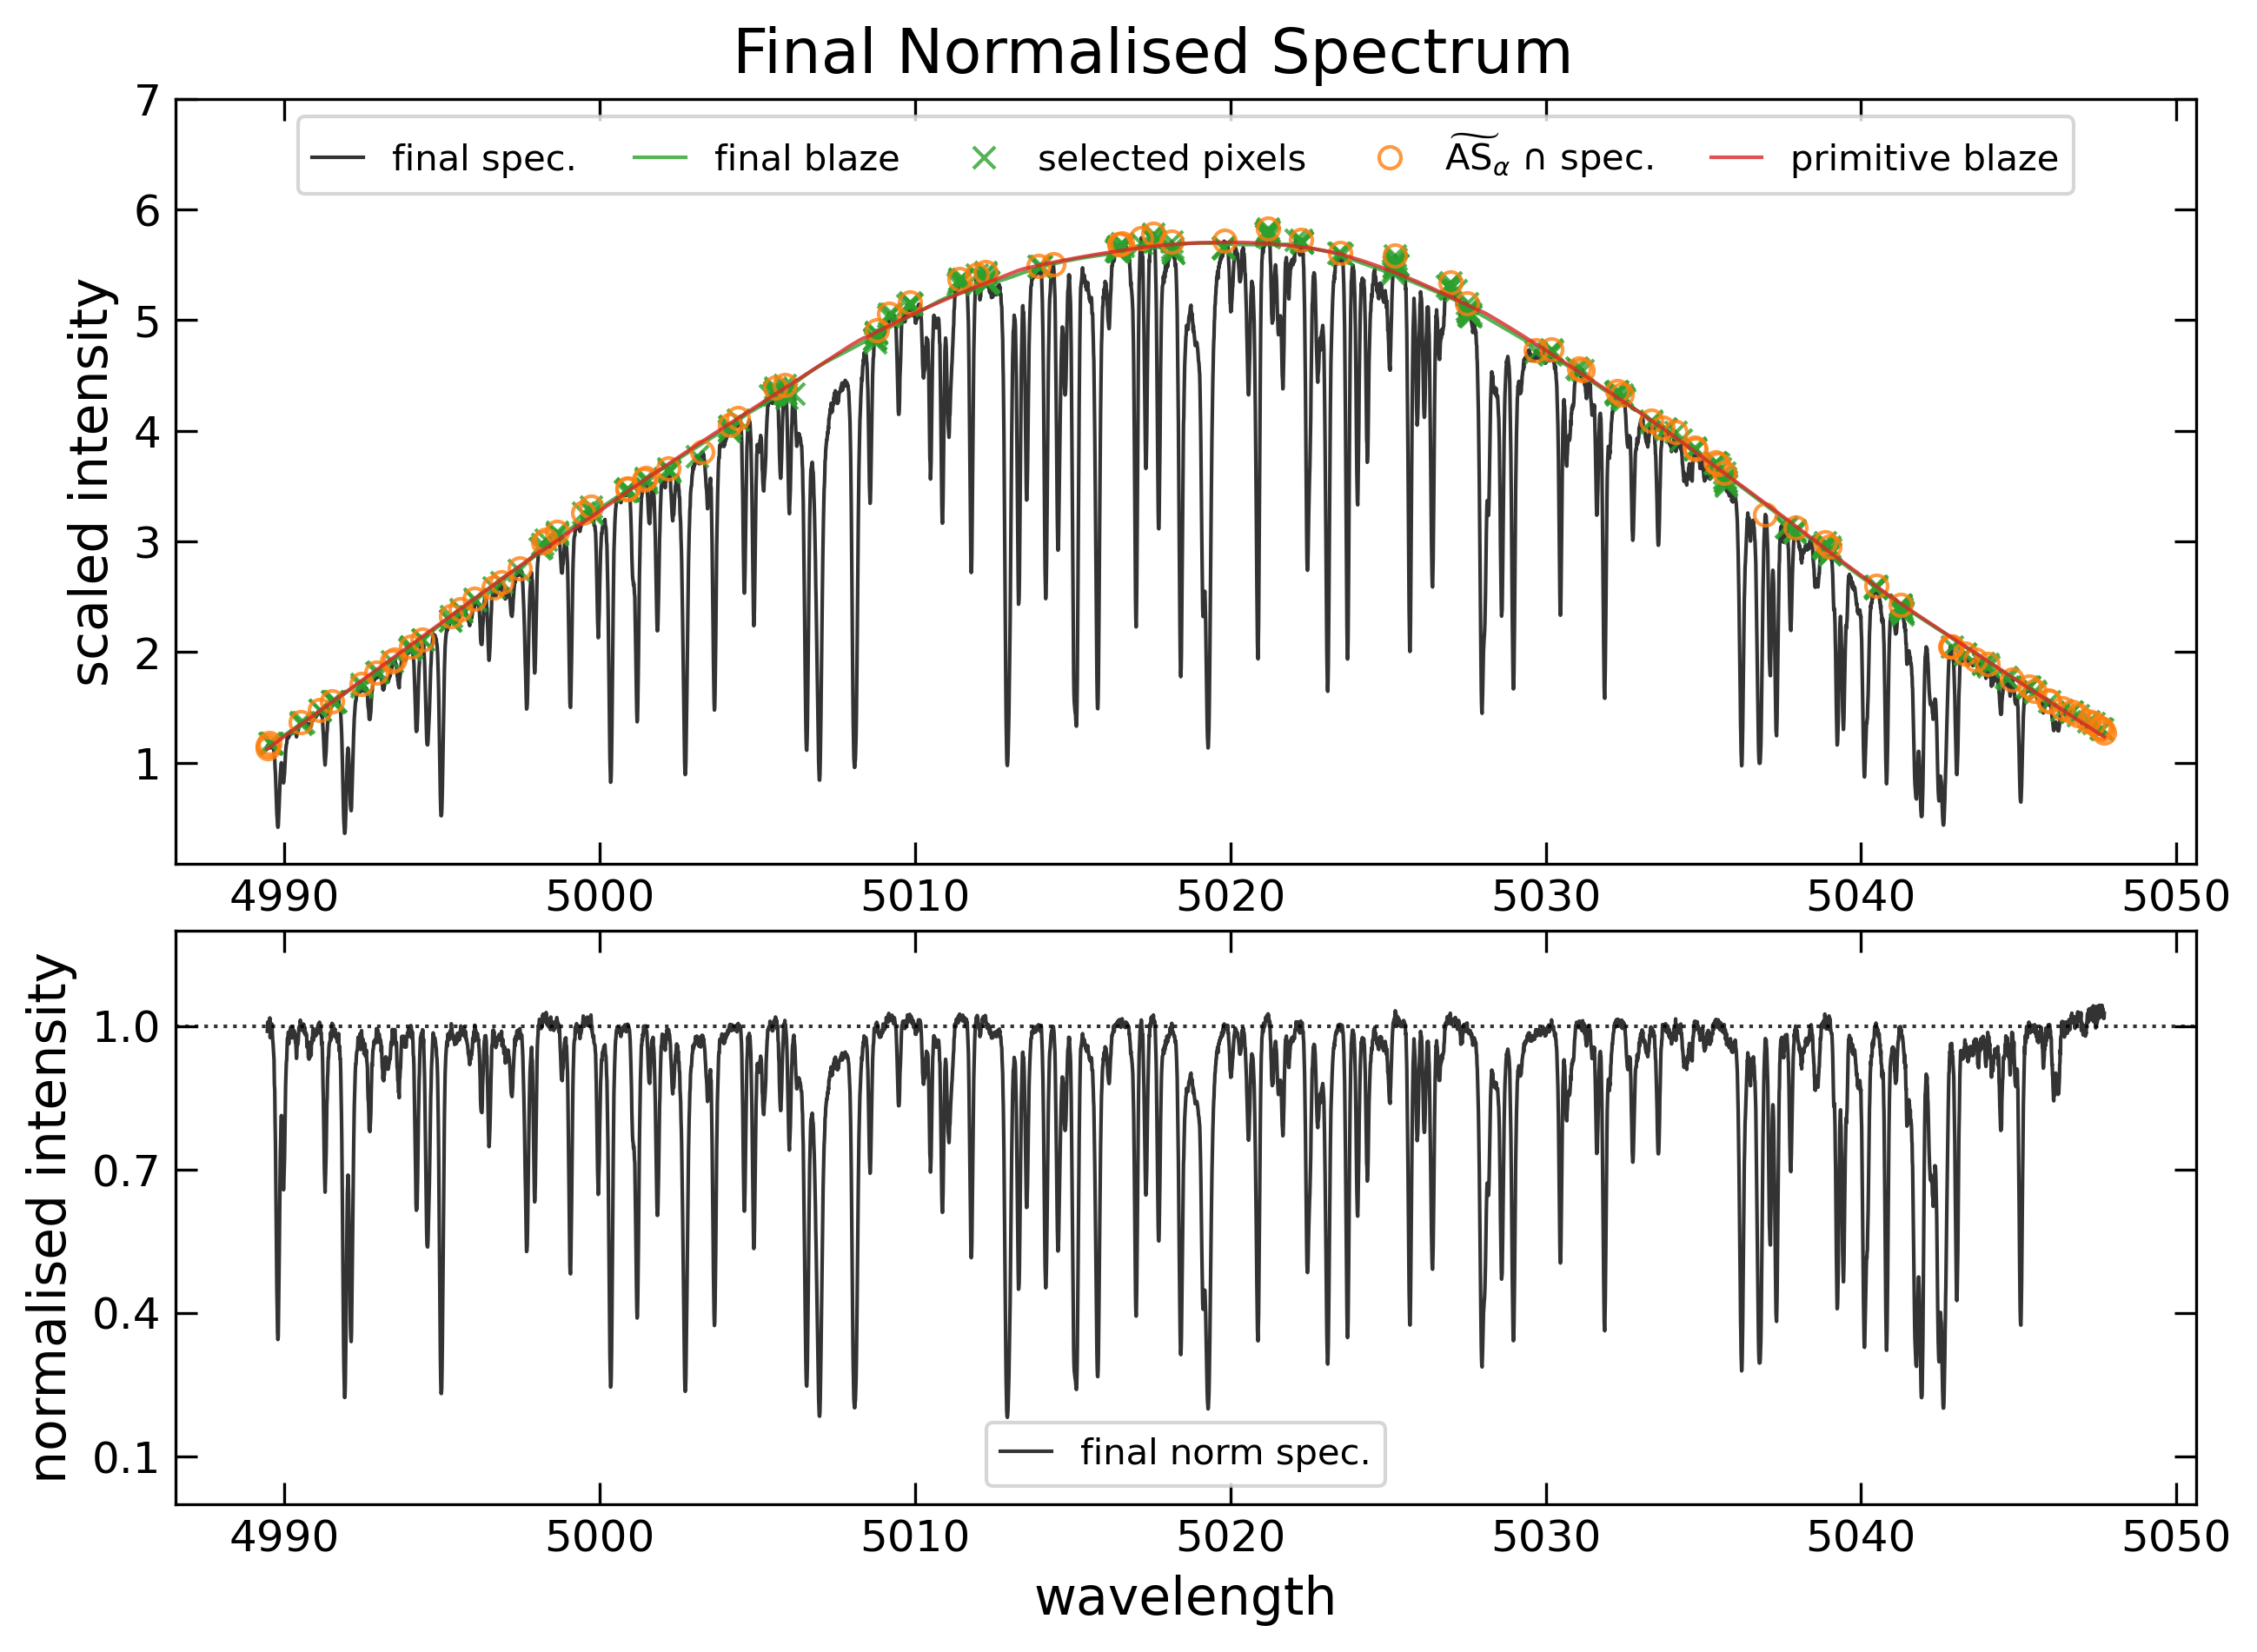

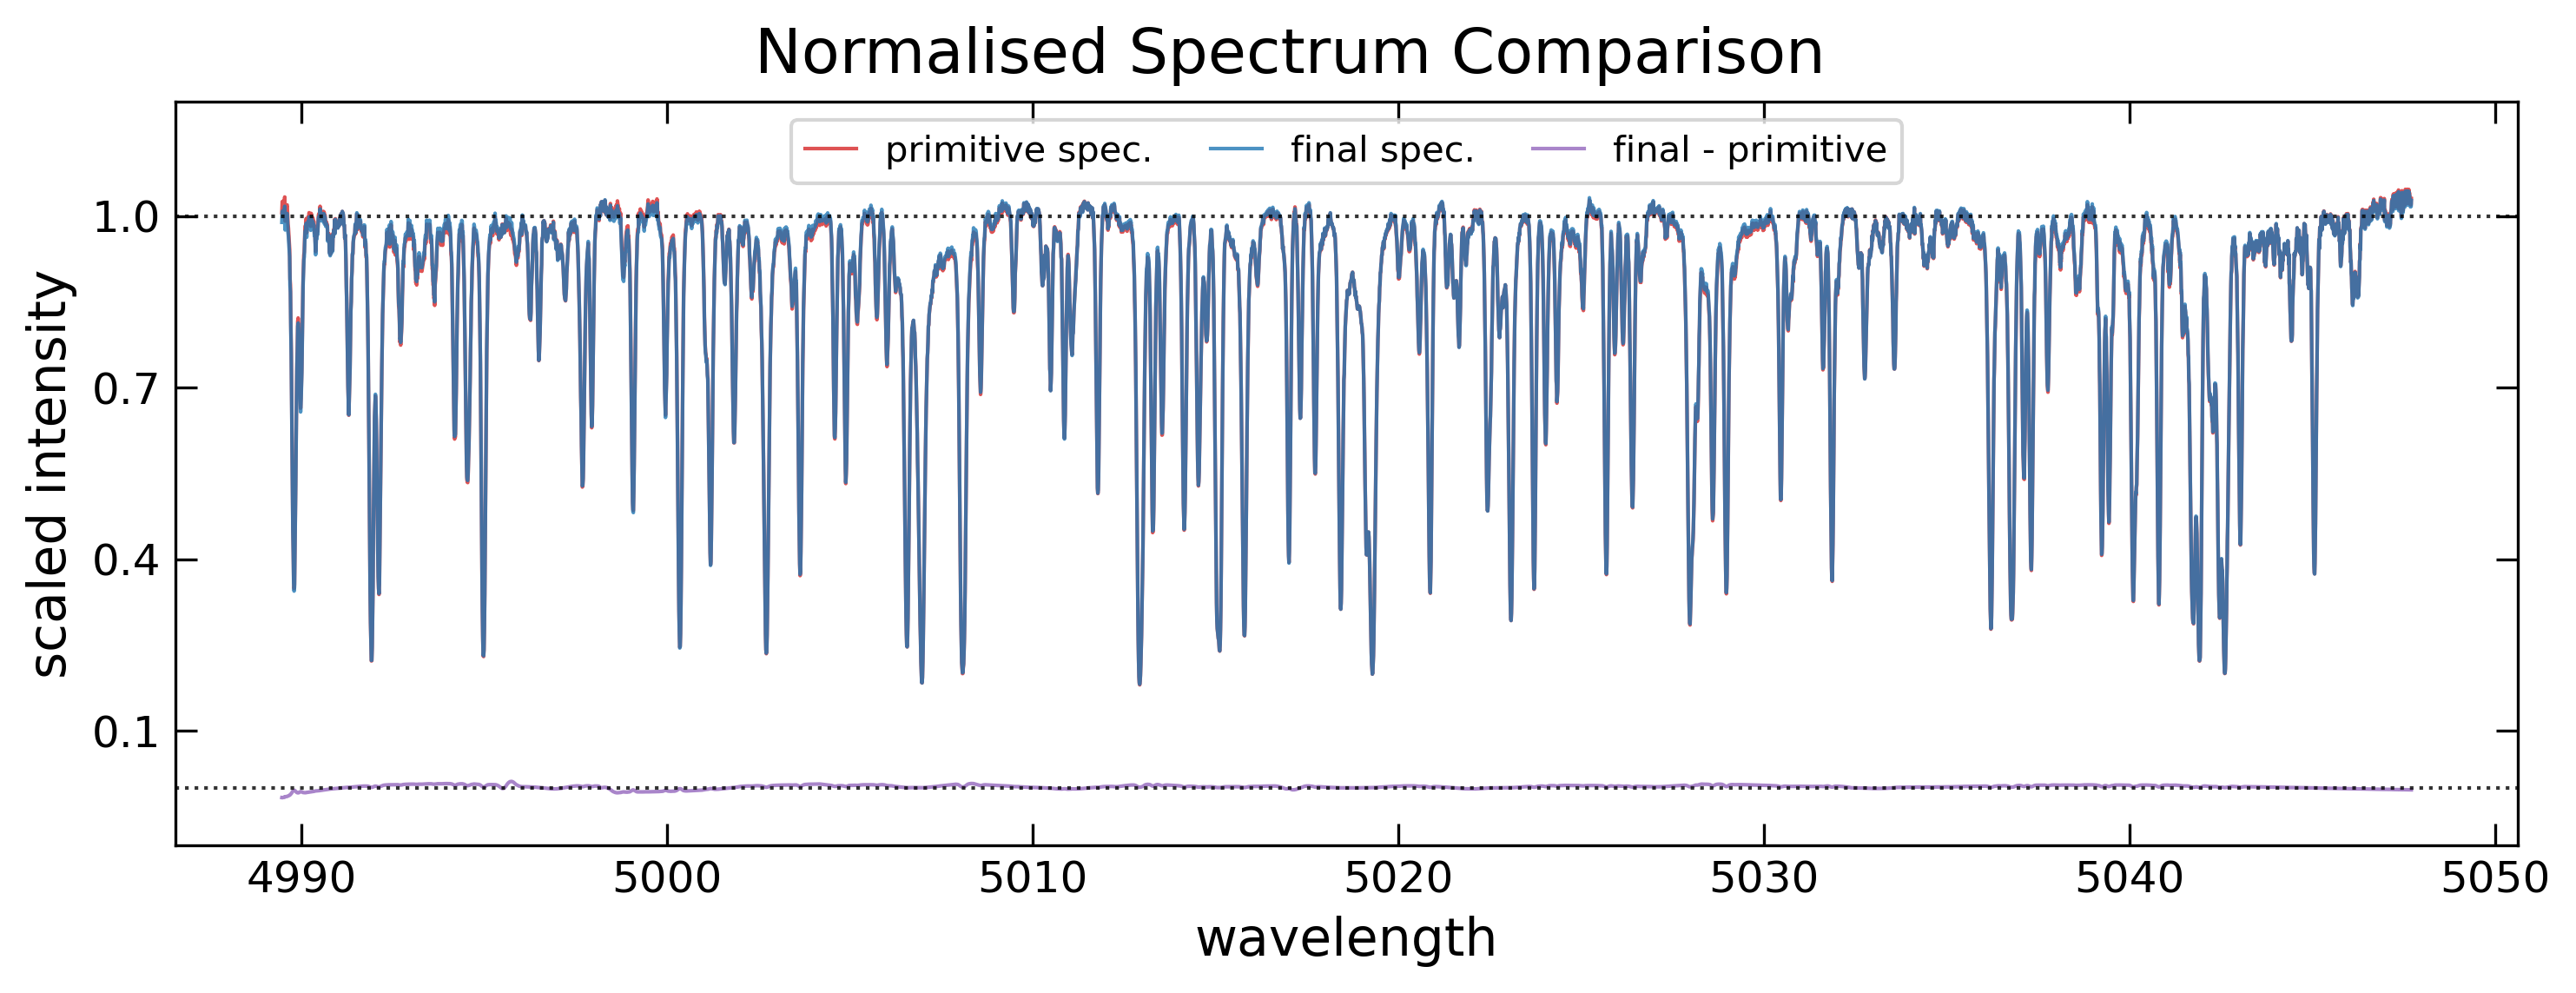

In [8]:
# run the AFS normalisation
spec_df['norm_flux'], debug_df = afs(
    wvl=spec_df['wvl'], intensity=spec_df['intensity'],
    is_remove_outliers=False,
    debug=True
)

In [9]:
# intermediate data
print(debug_df.columns)
debug_df.head(n=10)

Index(['wvl', 'intensity', 'scaled_intensity', 'is_outlier', 'tilde_AS_alpha',
       'is_intersect_with_tilde_AS_alpha', 'primitive_blaze',
       'primitive_norm_intensity', 'is_above_quantile', 'final_blaze',
       'final_norm_intensity'],
      dtype='object')


wvl    intensity  scaled_intensity  is_outlier  tilde_AS_alpha  \
0  4989.459023  13275.41016          1.132070       False        1.132070   
1  4989.470168  13555.55371          1.155959       False        1.155959   
2  4989.481313  13590.04980          1.158901       False        1.159851   
3  4989.492456  13561.42090          1.156460       False        1.163743   
4  4989.503600  13615.58594          1.161079       False        1.167634   
5  4989.514742  13681.70020          1.166717       False        1.171525   
6  4989.525884  13517.30078          1.152697       False        1.175416   
7  4989.537025  13829.33691          1.179307       False        1.179307   
8  4989.548166  13291.32129          1.133427       False        1.181425   
9  4989.559306  13492.75391          1.150604       False        1.183542   

   is_intersect_with_tilde_AS_alpha  primitive_blaze  \
0                              True         1.125287   
1                              True         1.127578   
2                             False         1.129874   
3                             False         1.132165   
4                             False         1.134456   
5                             False         1.136746   
6                             False         1.139037   
7                              True         1.141327   
8                             False         1.143617   
9                             False         1.145908   

   primitive_norm_intensity  is_above_quantile  final_blaze  \
0                  1.006028              False     1.144731   
1                  1.025171              False     1.146854   
2                  1.025690              False     1.148977   
3                  1.021459              False     1.151101   
4                  1.023468              False     1.153226   
5                  1.026365              False     1.155351   
6                  1.011993              False     1.157477   
7                  1.033277               True     1.159603   
8                  0.991089              False     1.161729   
9                  1.004098              False     1.163856   

   final_norm_intensity  
0              0.988940  
1              1.007940  
2              1.008637  
3              1.004655  
4              1.006809  
5              1.009837  
6              0.995871  
7              1.016992  
8              0.975638  
9              0.988613

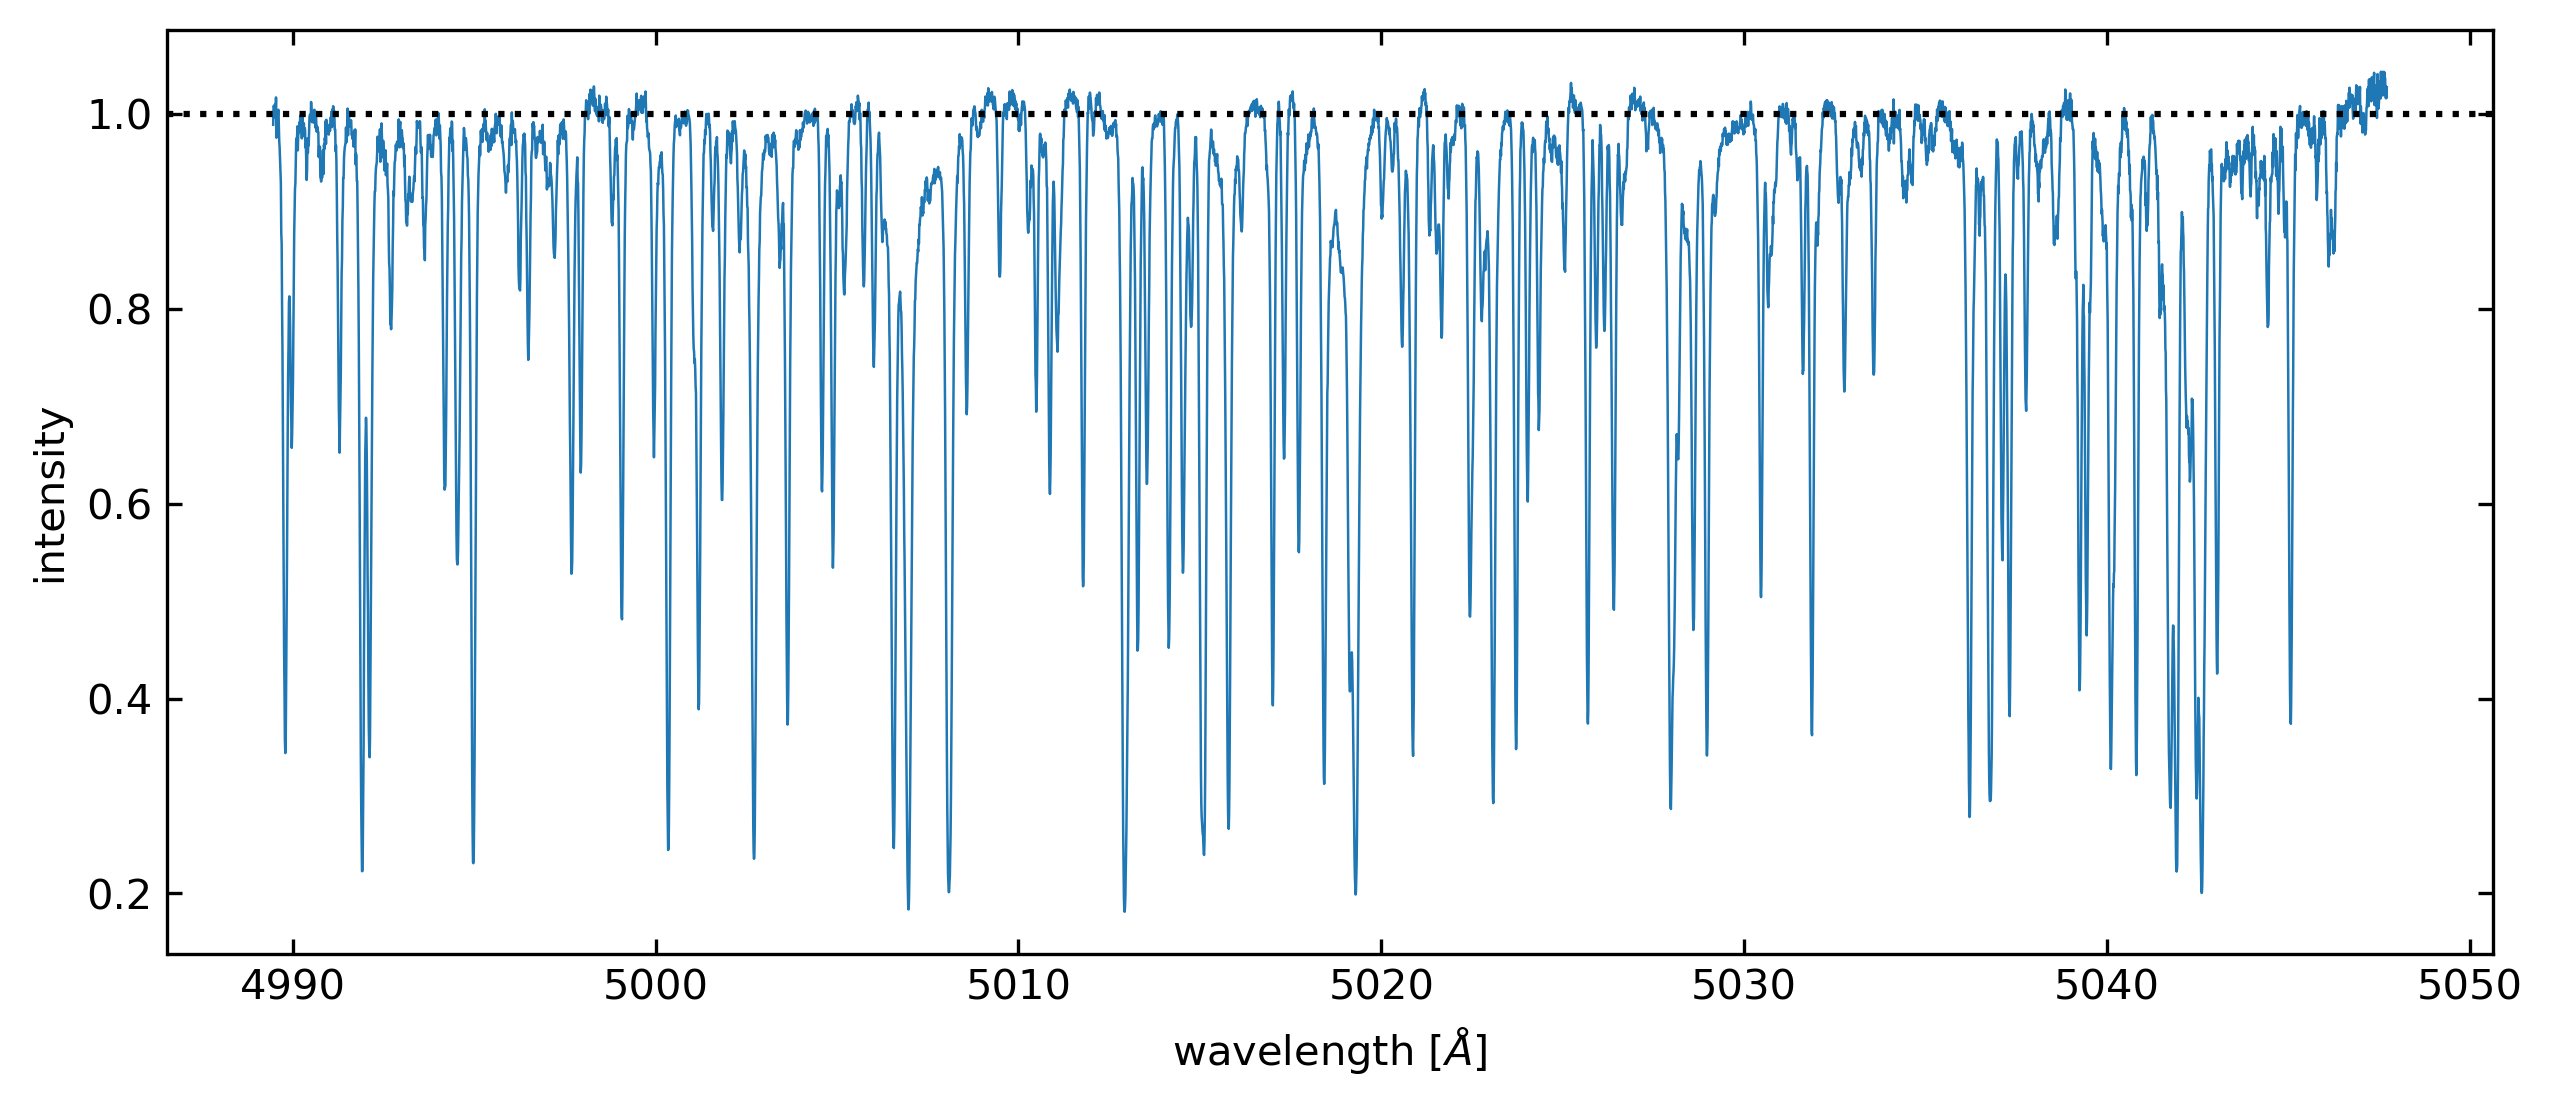

In [10]:
# visualisation of the normalised spectrum
plot_norm_spec(spec_df, 'norm_flux')

# Flattening Parameters Fine-tune

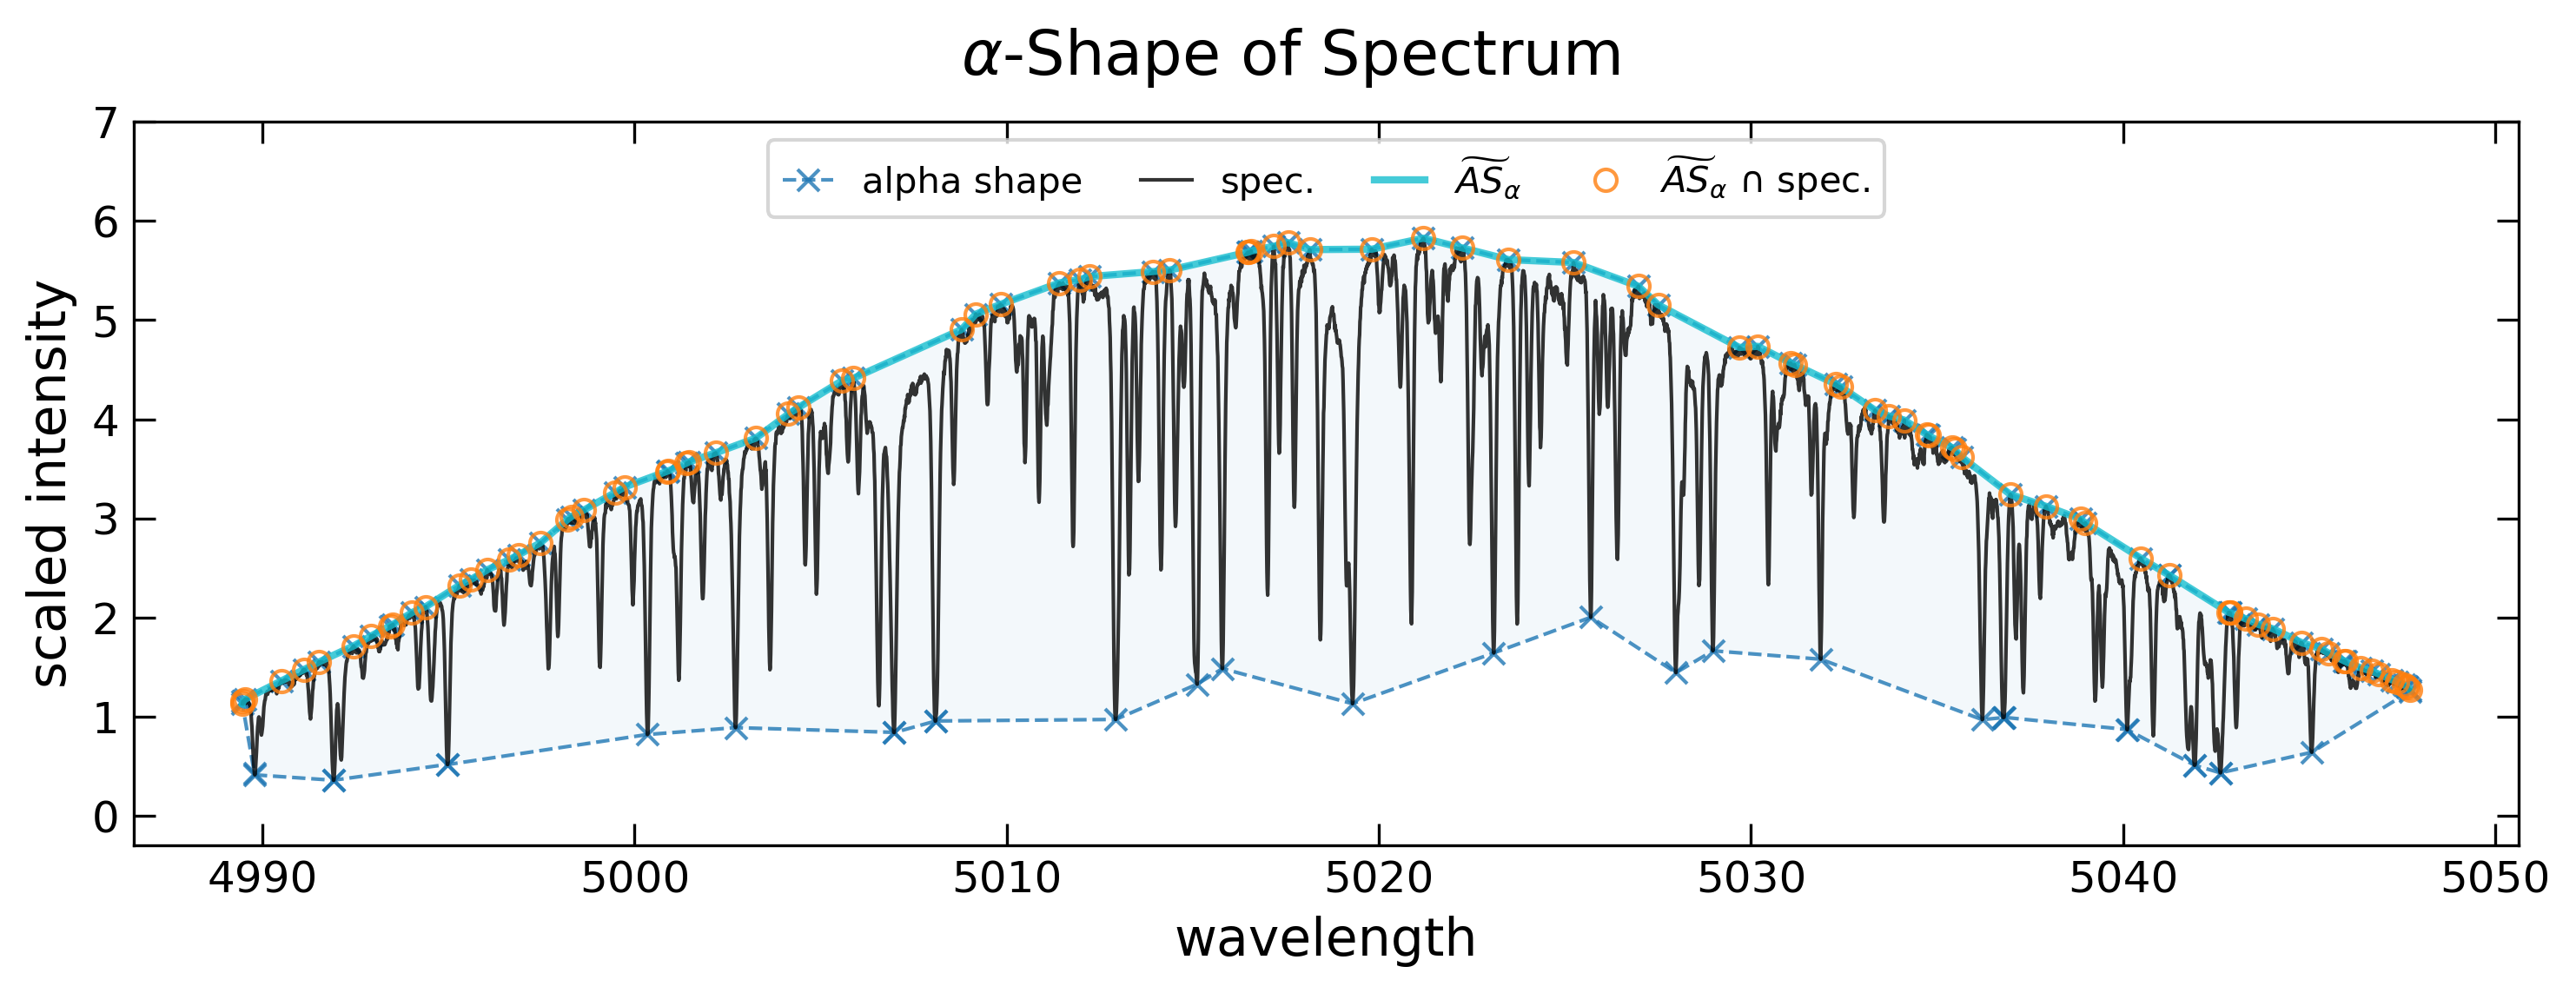

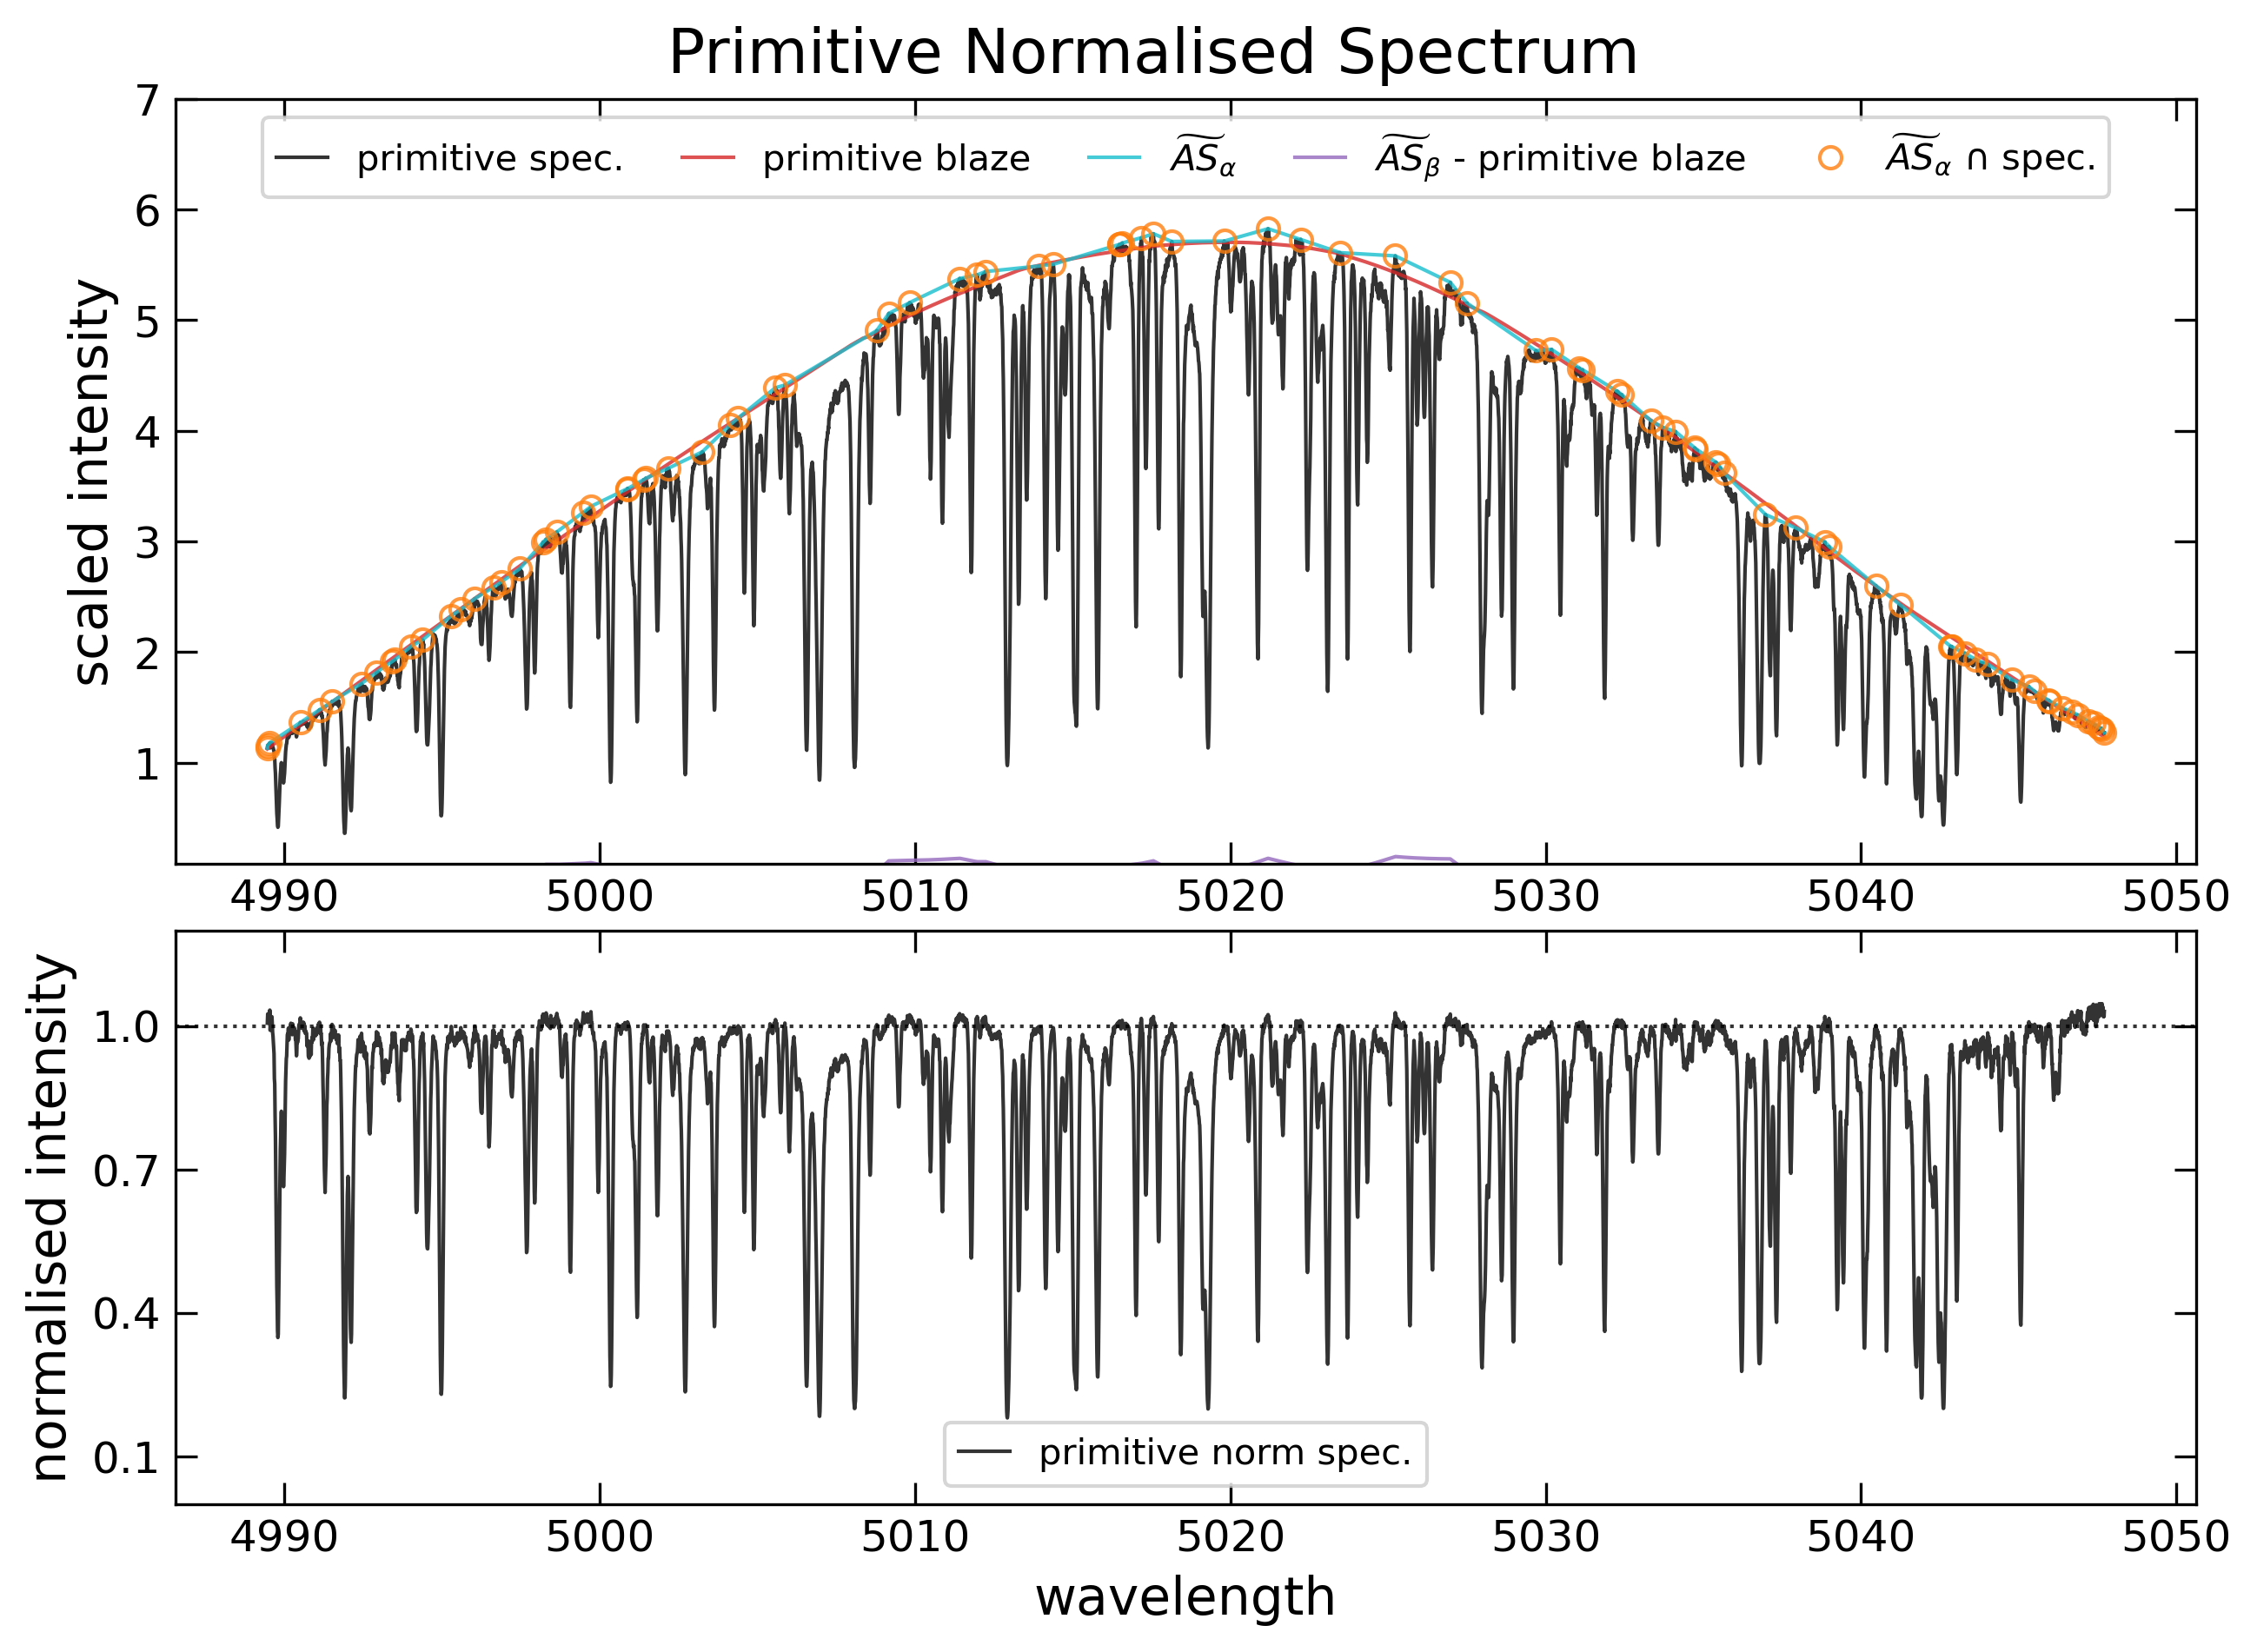

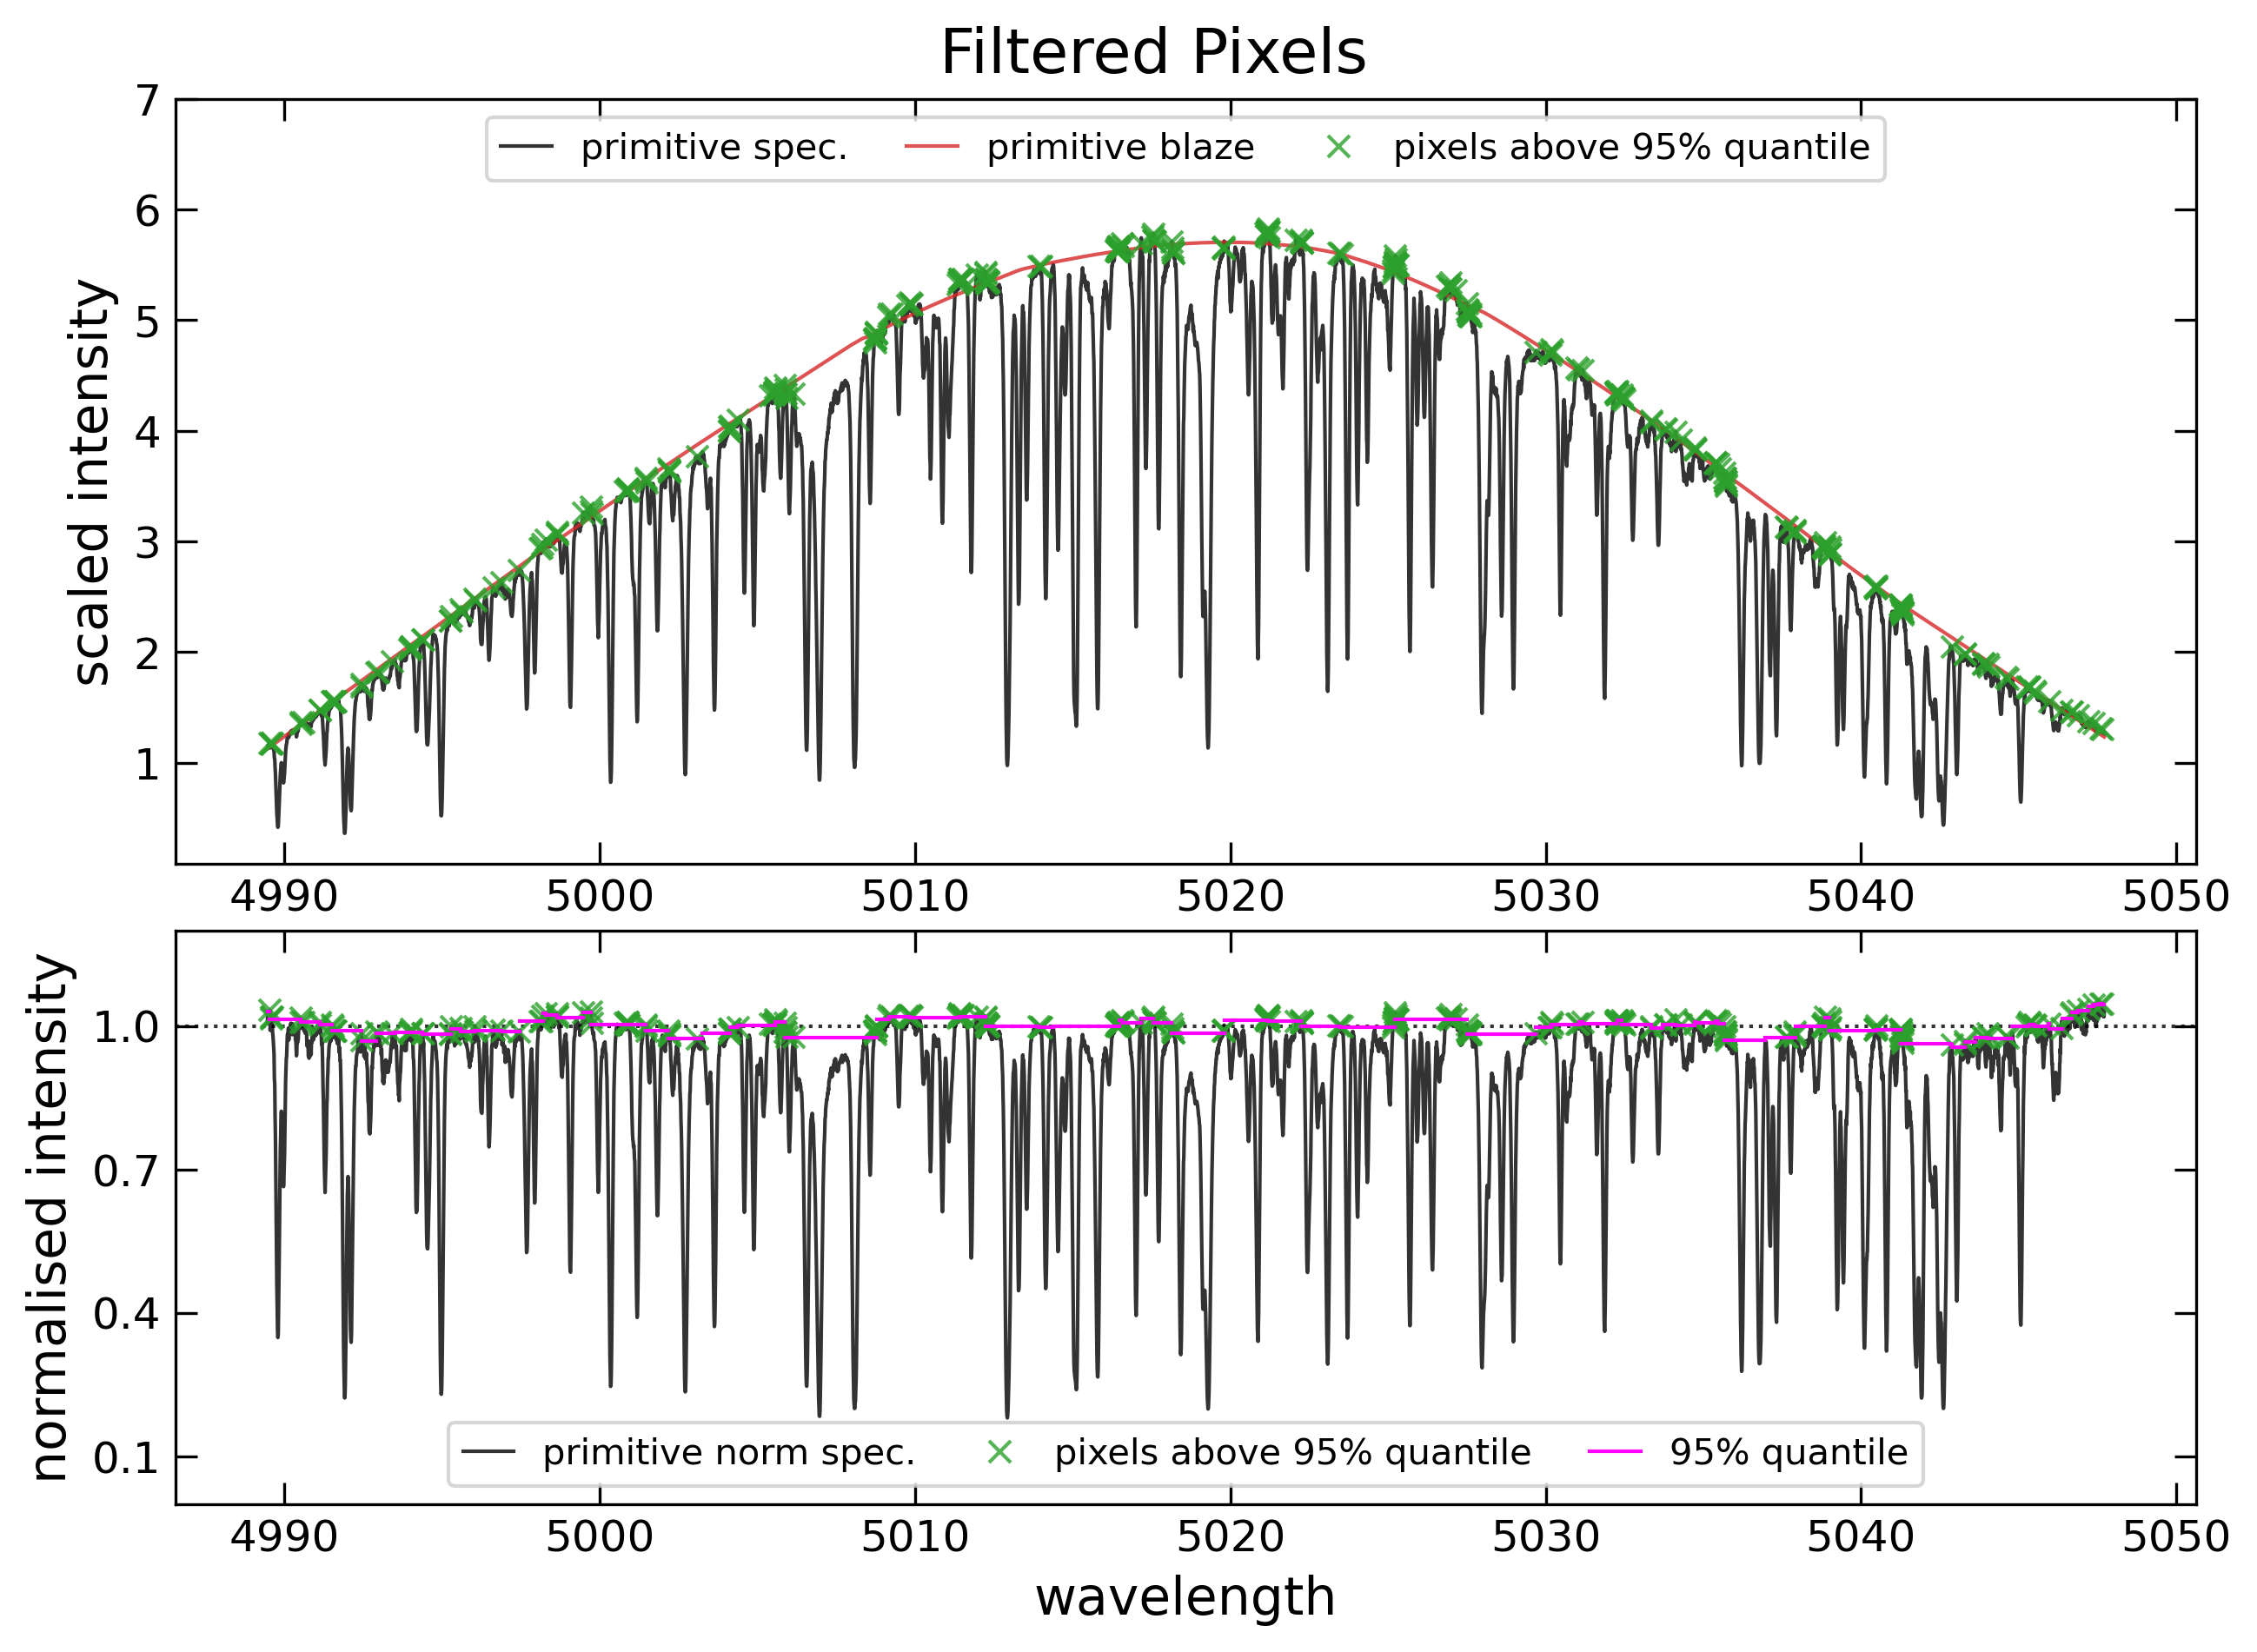

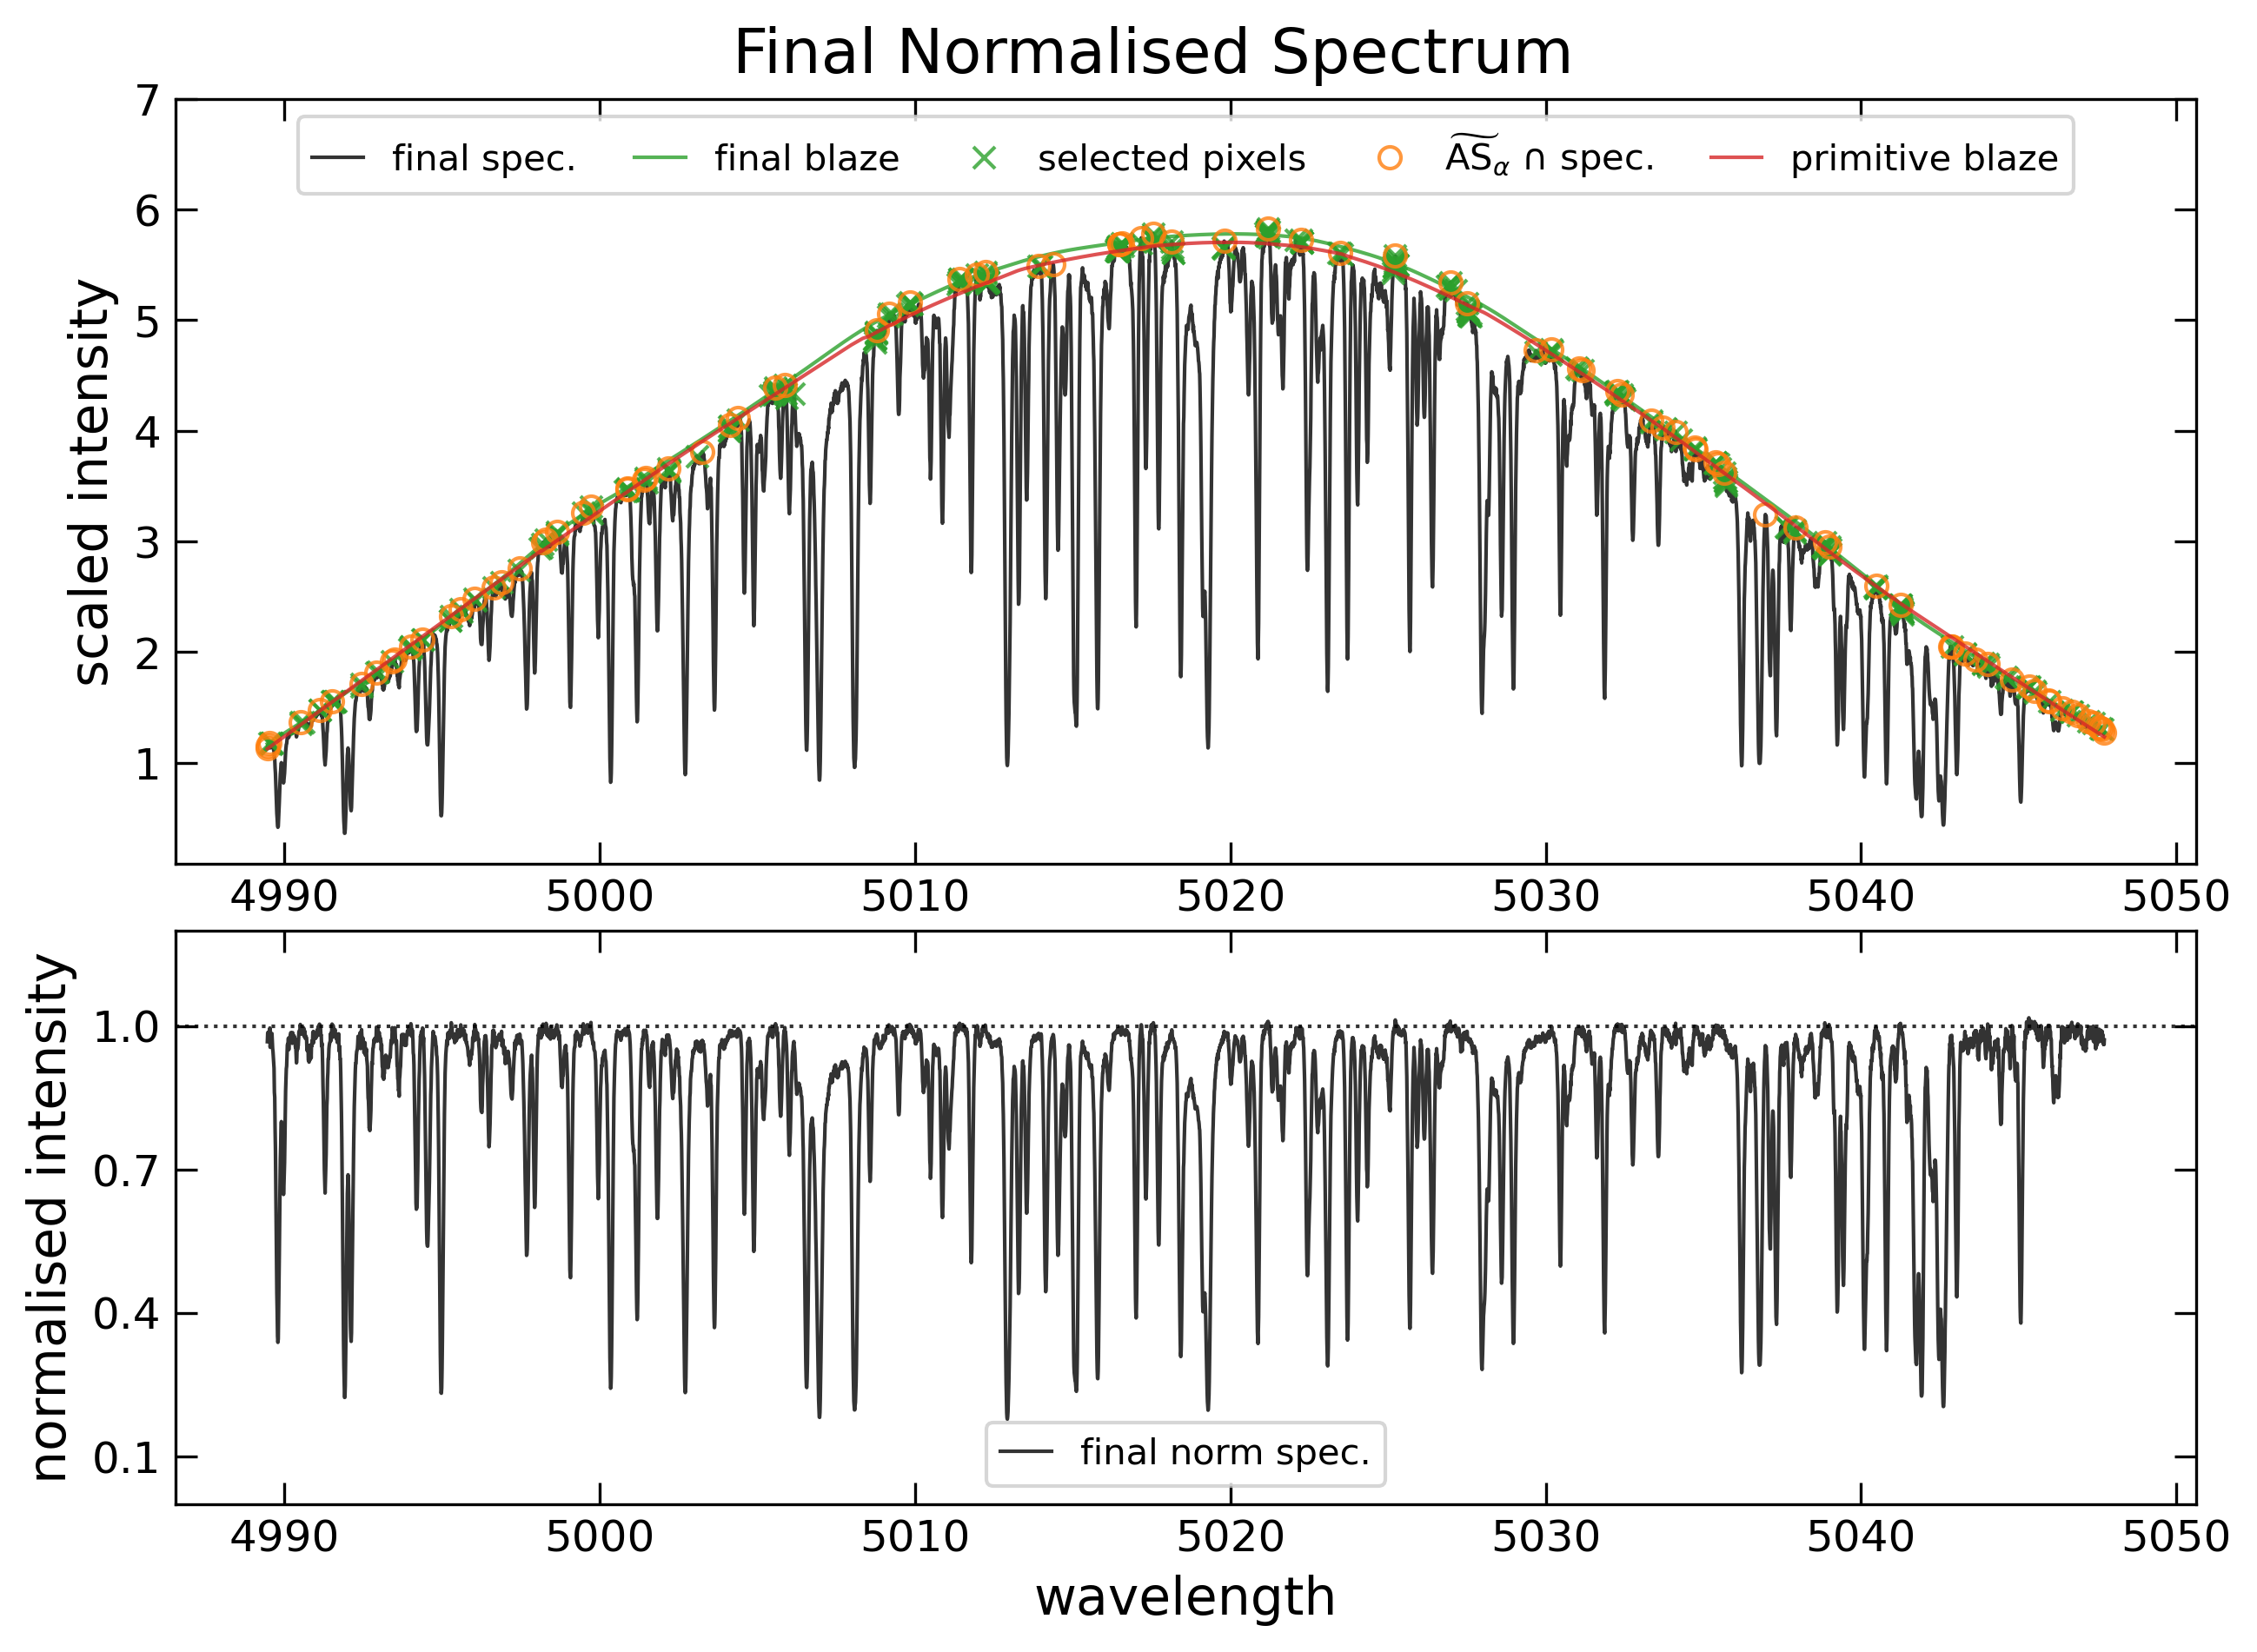

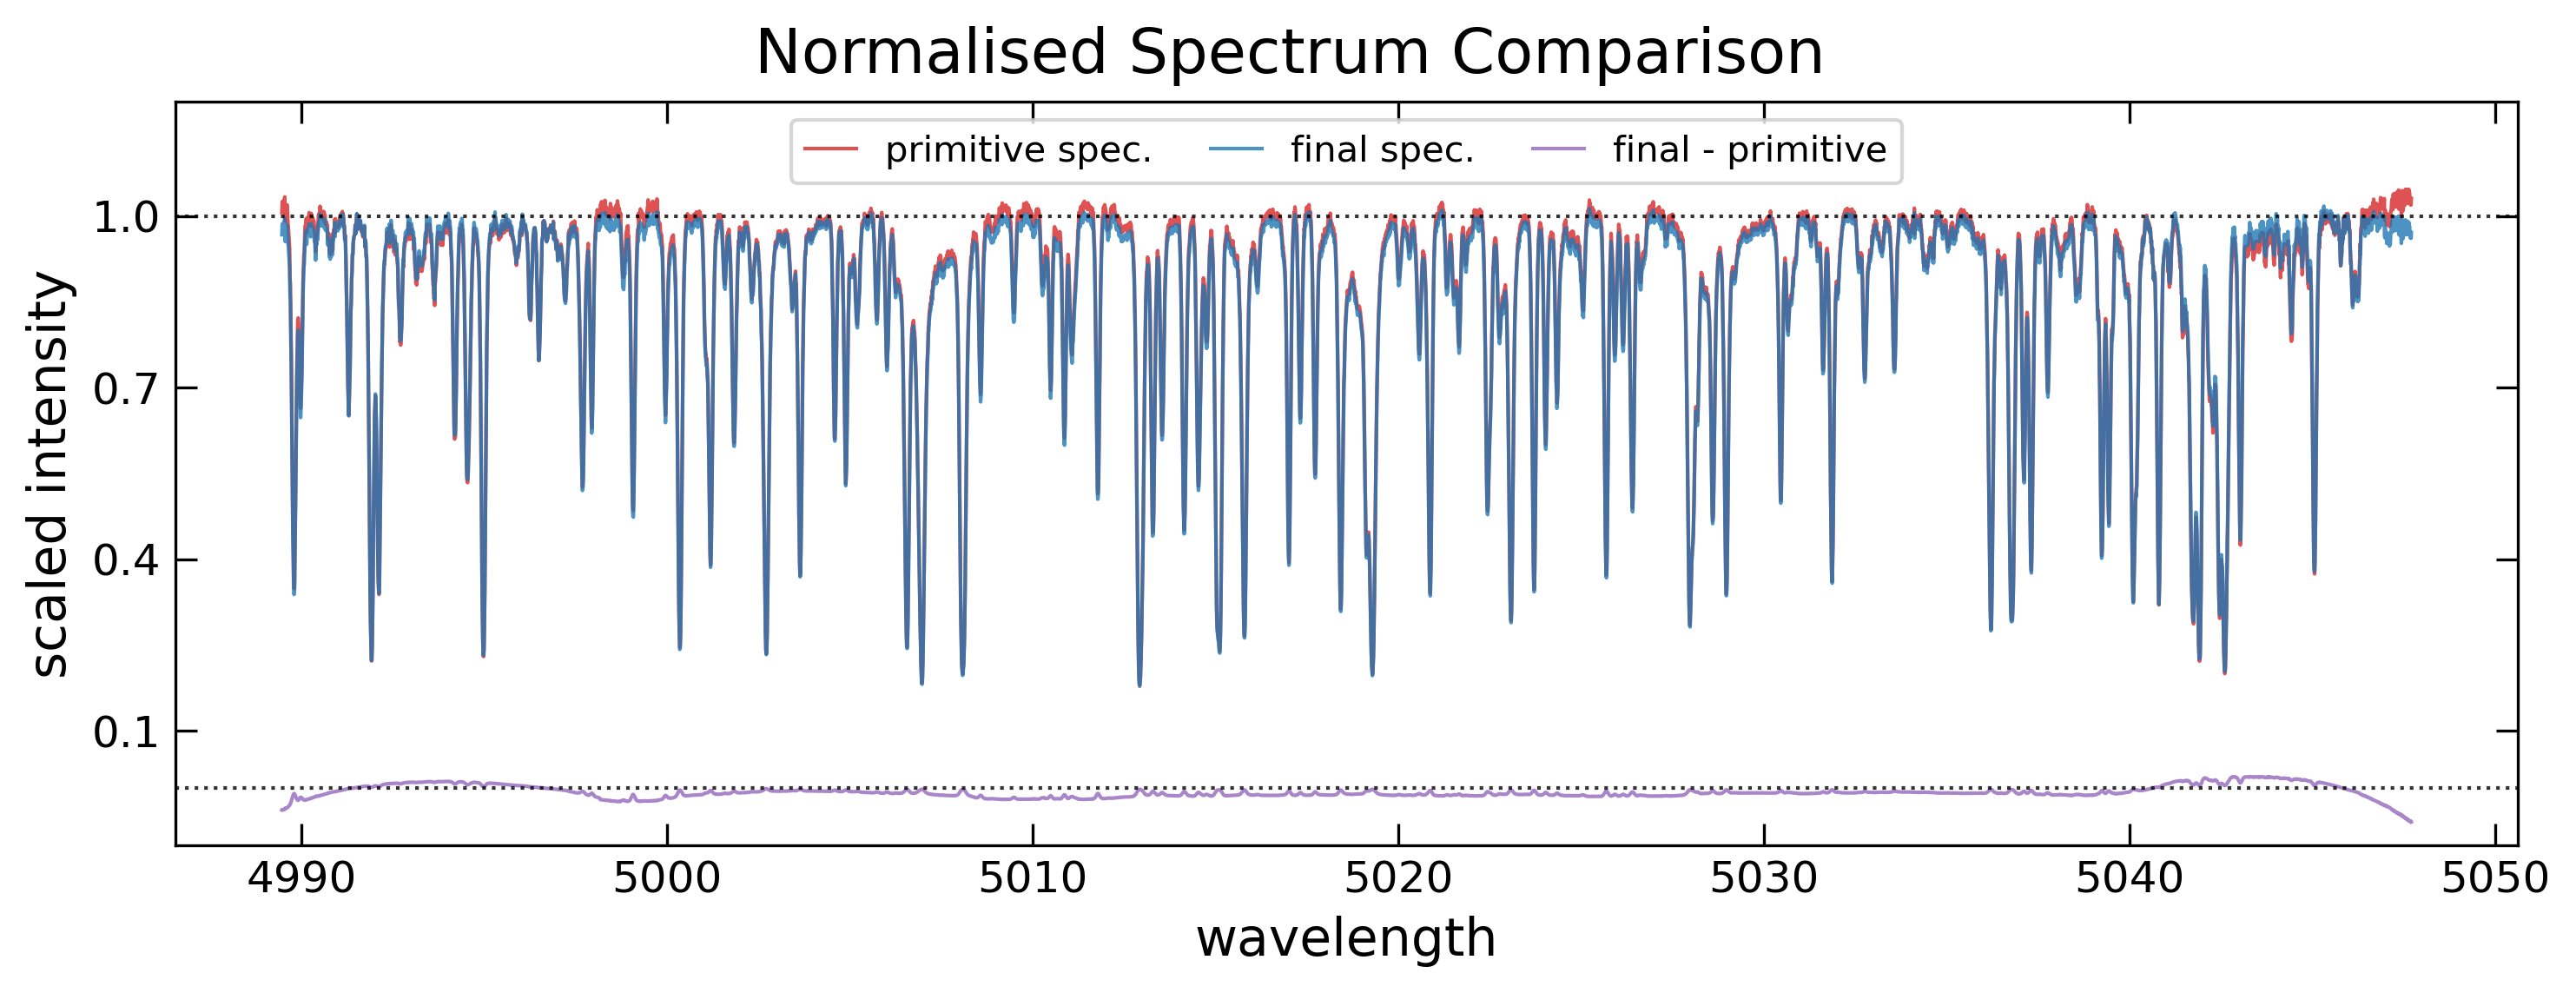

In [11]:
# include the intersection points
spec_df['mod_norm_flux'], debug_df = afs(
    wvl=spec_df['wvl'], intensity=spec_df['intensity'],
    is_include_intersections=True,
    is_remove_outliers=False,
    debug=True
)

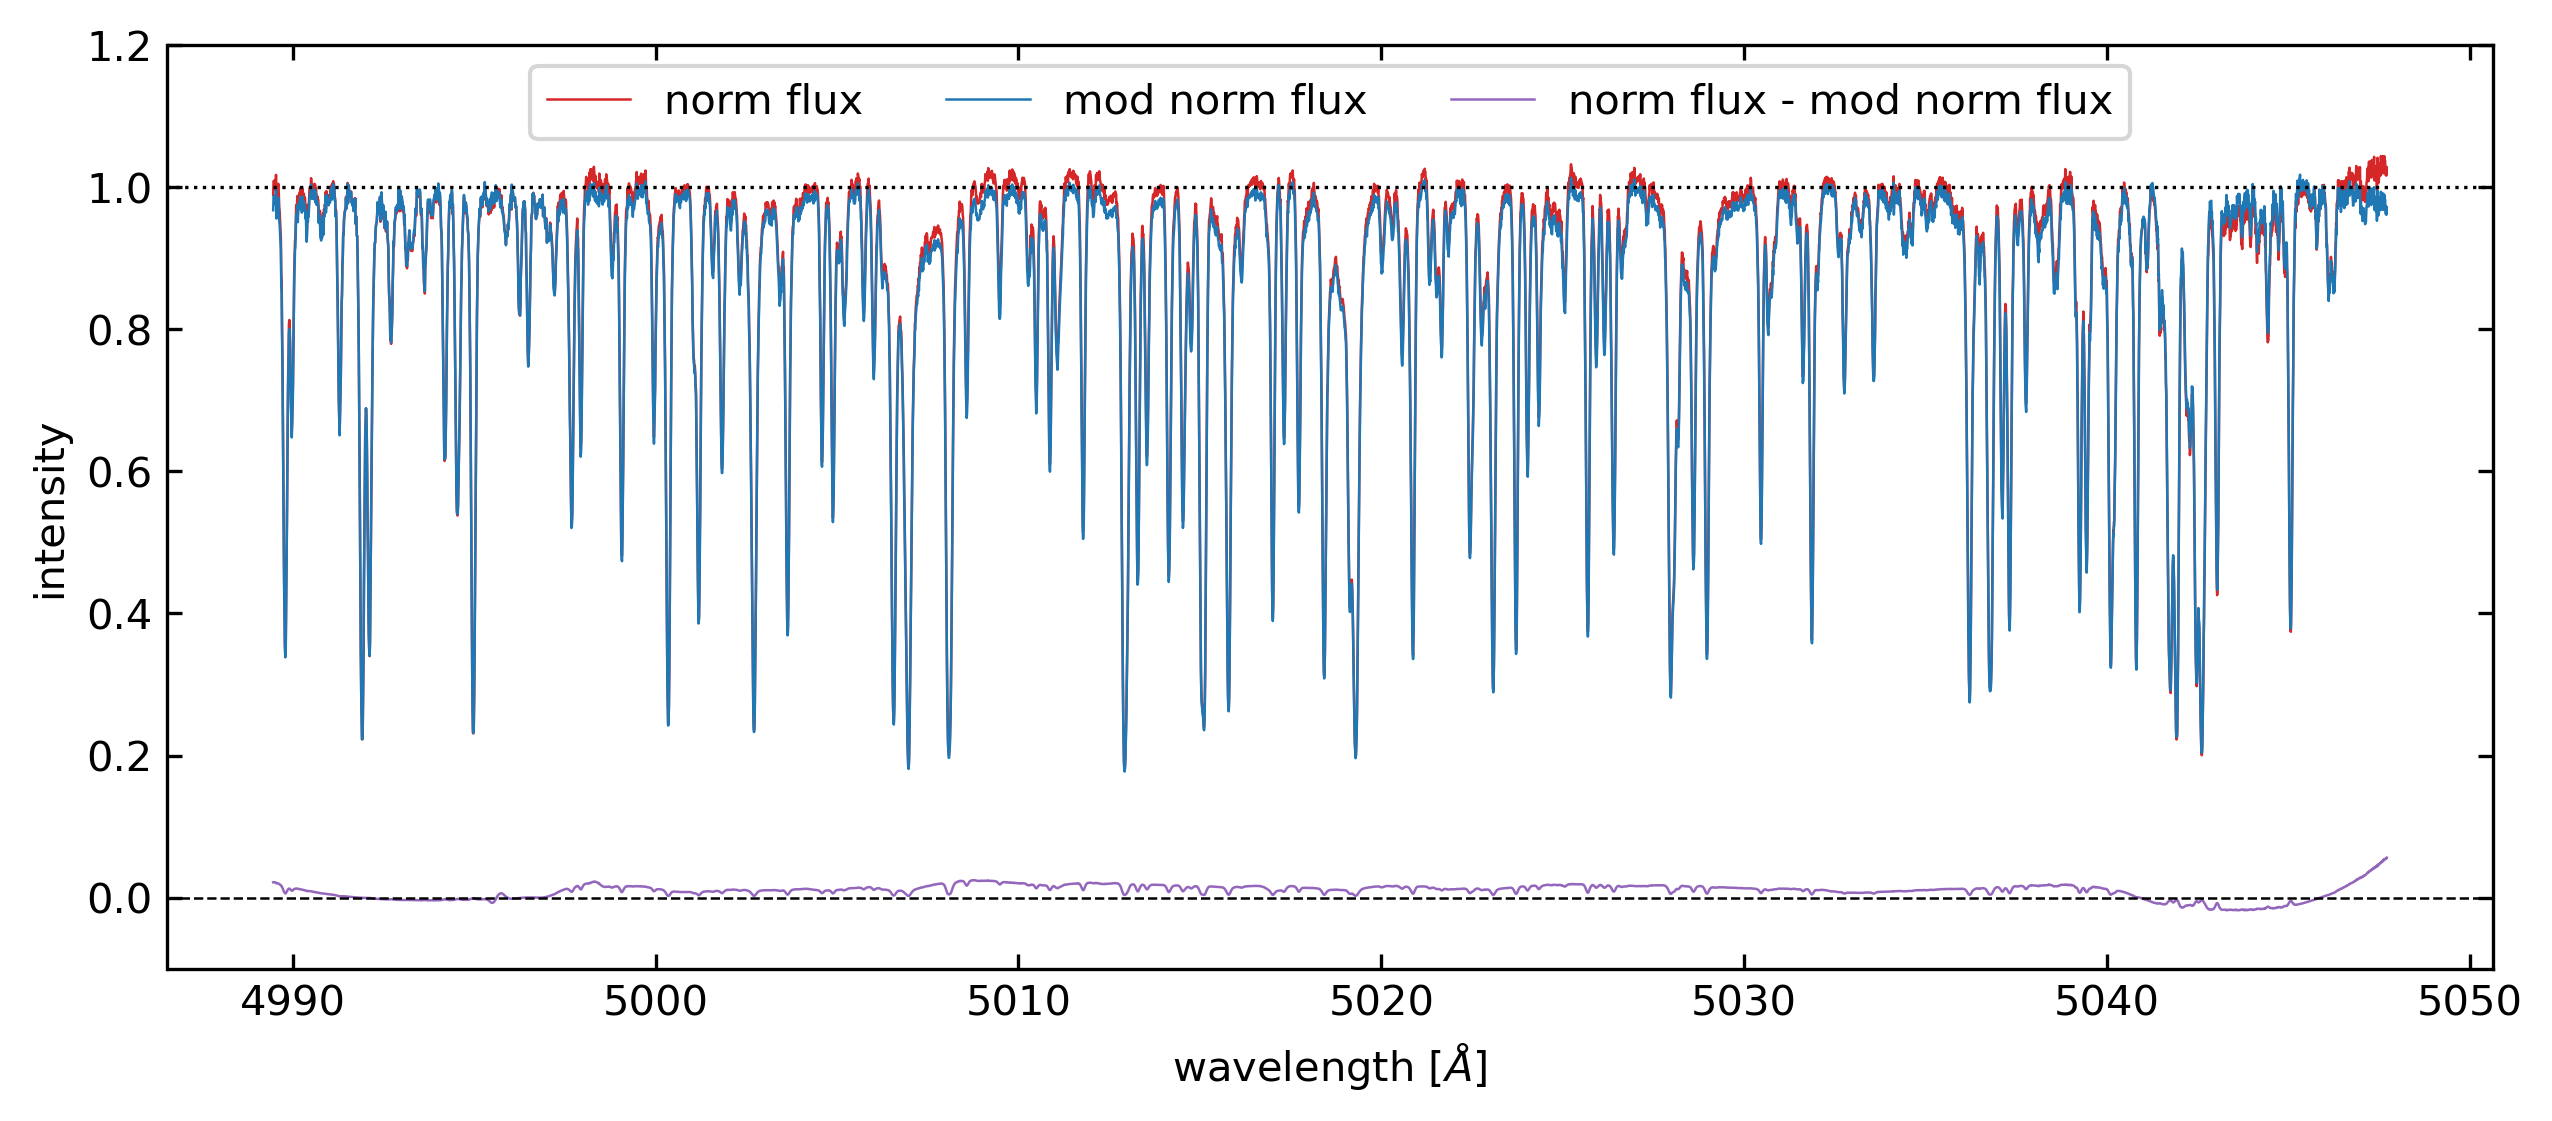

In [12]:
plot_norm_spec_compare(spec_df, 'norm_flux', 'mod_norm_flux')